# Learning delays (v2)


Edit2: I have collected most of the delay related functions and variables to a DelayLayer class. Applied surrogate update to delays as suggested by (Tomas Fiers, Markus Ghosh and Alessandro Galloni). In this update, method A is used. In addition, I completely changed the code of the delay layer forward function as there was a bug with the one supplied by pytorch (it was very time consuming to find and fix this bug). In this update, I will demonstrate that the delay layer works, apply to a modified sound the localization problem (I will explain why the modification) and state what are the challenges with 1-layer differentiable delays.
Also, in this update, I will show conceptually how delays can be learned in a more biological SNN using Brian2.


I will start with the concept as shown in the below figure.
<br/><br/>




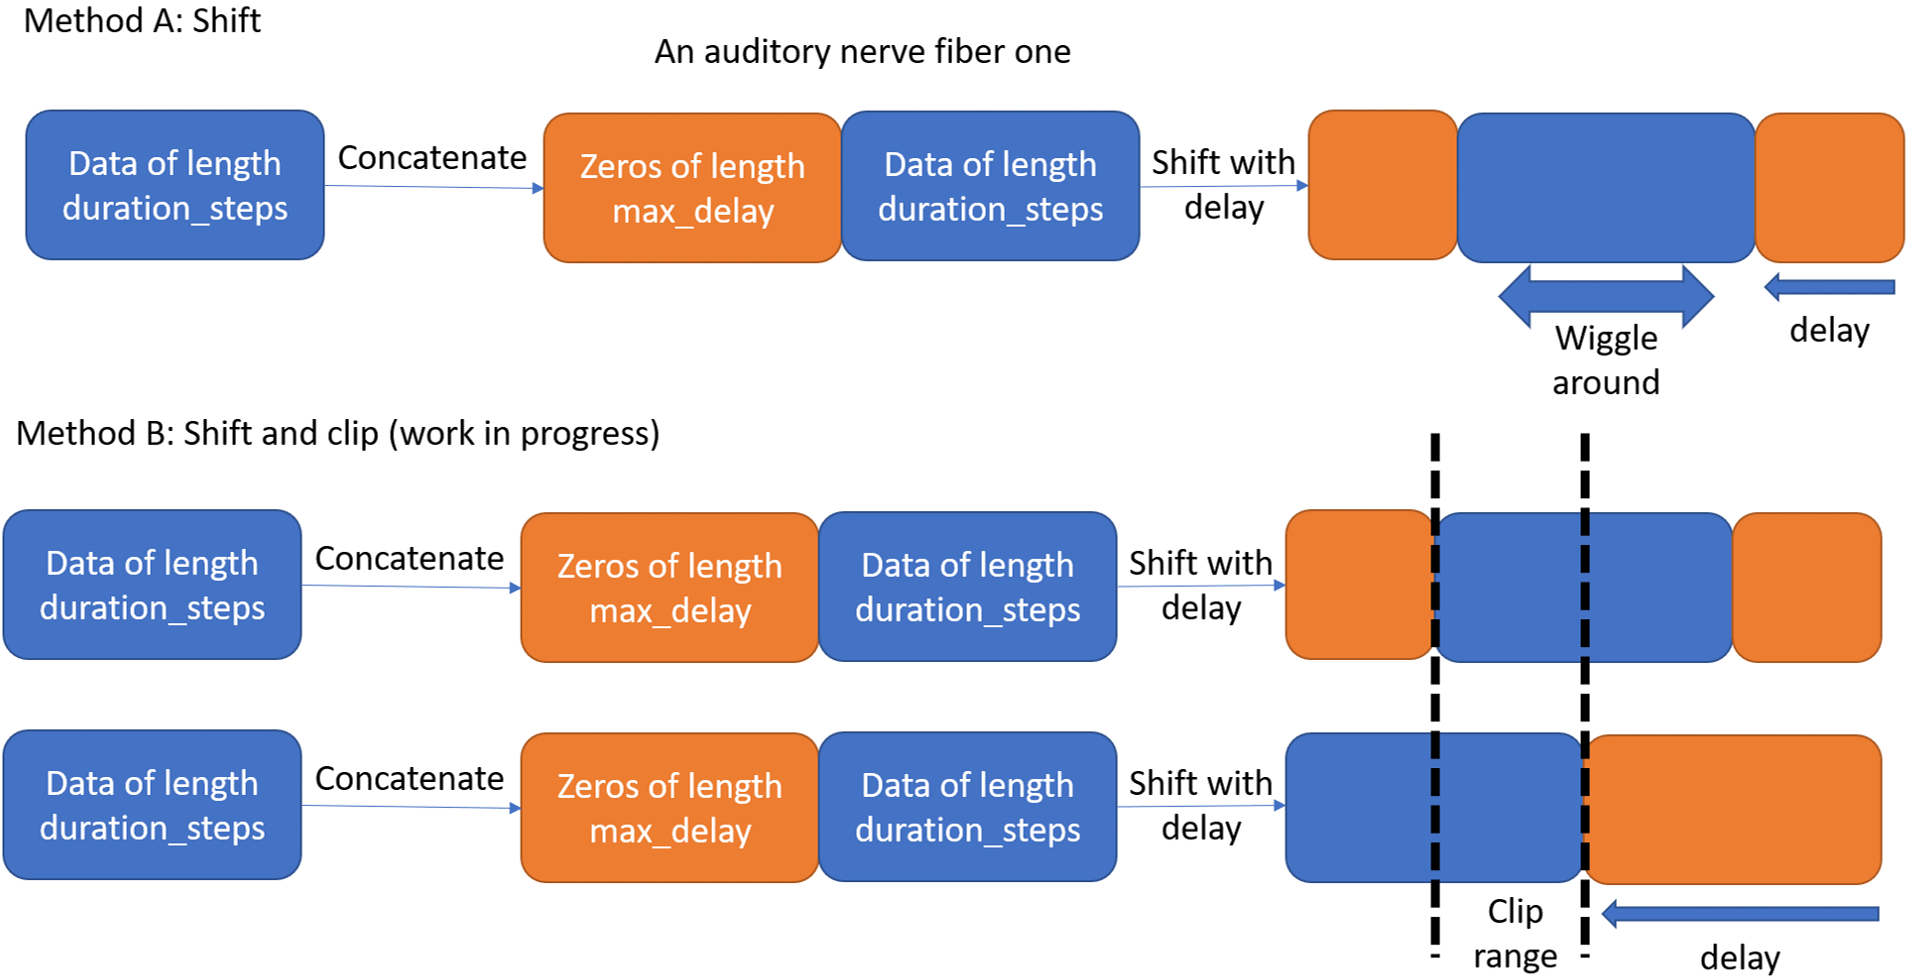

Method A: the aim is to pad the output spikes with a tensor of zeros then apply a delay. This will shift the spikes as shown in the figure, then the data will be surronded by zeros from both sides.




## Delay toy problems

In [ ]:
#@title Imports
!pip install brian2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import brian2 as br

dtype = torch.float
torch.set_printoptions(precision=8, sci_mode=False, linewidth=200)
np.set_printoptions(precision=10, suppress=True)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
#@title Defintions

# Stimulus and simulation parameters
DURATION_TRUE = 20  # Input pattern duration
MAX_DELAY = 40  # Maximum allowed delay
DURATION_ZEROS = 20  # Size of the zero padding to the input pattern
DURATION_STEPS = DURATION_ZEROS * 3 + DURATION_TRUE  # Full duration length (used in synaptic integration)
EFFECTIVE_DURATION = DURATION_STEPS
NUMBER_CLASSES = 20
NUMBER_INPUTS = 3  # The larger the harder the problem
BATCH_SIZE = 500
NB_EPOCHS = 4000
TAU, TAU_DECAY, TAU_DECAY_FLAG = 10, 0.04, False  # Decaying tau can lead to better performance put needs adjustment.
ROUND_DECIMALS = 4  # For the stability of differentiating delays
MAX_SUM = np.zeros((NUMBER_CLASSES,))  # A part of the loss function
MULTIPLY_ALL = False  # Set to False for faster convergence or if there is no convergence.
FIX_FIRST_INPUT = True  # Set to true for faster convergence or if there is no convergence.
PROP_ONES = 0.3  # Probability of spikes in a pattern
INPUT_PATTERN = np.random.choice([0, 1], size=(NUMBER_INPUTS, NUMBER_CLASSES, DURATION_TRUE),
                                 p=[1-PROP_ONES, PROP_ONES])
INPUT_PATTERN_LENGTH = INPUT_PATTERN.shape[2]
INPUT_PATTERN_2 = np.random.choice([0, 1], size=(NUMBER_CLASSES, NUMBER_INPUTS, NUMBER_CLASSES, DURATION_TRUE),
                                   p=[1-PROP_ONES, PROP_ONES])
INPUT_PATTERN_3 = np.zeros([NUMBER_INPUTS, NUMBER_CLASSES, DURATION_TRUE])
INPUT_PATTERN_3[:, :, :] = INPUT_PATTERN[0, 0, :]
SAME_PATTERN = True  # Patterns of different classes are the same
if SAME_PATTERN:
    INPUT_PATTERN = INPUT_PATTERN_3.copy()
ALL_RANDOM_FLAG = False  # If true, the same neuron will output different spikes for different target neurons (Unsolvable for now)
SHOW_IMAGE = False  # In results, show image or only significant input/output pairs

Creates all the input-targets pairs for training. This function is called once.

In [3]:
#@title Generation of input-target pairs for training
def create_input_targets(duration=20, number_inputs=2, classes=20, duration_zeros=20):
    inputs_temp = np.zeros([number_inputs, classes, duration])
    zero_padding = np.zeros([number_inputs, classes, duration_zeros])
    targets_temp = np.zeros(classes)
    inputs_targets = []
    if ALL_RANDOM_FLAG:
        for idx in range(classes):
            inputs_copy = INPUT_PATTERN_2[idx, :, :, :].copy()
            inputs_copy = np.concatenate((zero_padding, zero_padding, inputs_copy, zero_padding), axis=2)
            targets_copy = targets_temp.copy()
            targets_copy[idx] = 1
            inputs_targets.append((inputs_copy, targets_copy))
    else:
        for idx in range(classes):
            inputs_temp[0, :, :] = INPUT_PATTERN[0, idx, :]
            inputs_copy = inputs_temp.copy()
            inputs_copy = np.concatenate((zero_padding, zero_padding, inputs_copy, zero_padding), axis=2)
            for idy in np.arange(1, NUMBER_INPUTS, 1):
                rand_poistion = np.random.randint(0, duration)
                inputs_copy[idy, :, 2*duration_zeros + rand_poistion:2*duration_zeros + rand_poistion +
                            INPUT_PATTERN_LENGTH] = INPUT_PATTERN[idy, idx, :]
            targets_copy = targets_temp.copy()
            targets_copy[idx] = 1
            inputs_targets.append((inputs_copy, targets_copy))
    return inputs_targets

In [4]:
#@title Getting the training patch
input_targets_all = create_input_targets(duration=DURATION_TRUE, number_inputs=NUMBER_INPUTS,
                                         classes=NUMBER_CLASSES, duration_zeros=DURATION_ZEROS)
def generate_input_targets(in_tar, n=NUMBER_CLASSES):
    while True:
        yield in_tar[np.random.choice(n)]


def get_batch():
    inputs, targets = [], []
    for _ in range(BATCH_SIZE):
        value = next(generate_input_targets(input_targets_all))
        inputs.append(value[0])
        targets.append(value[1])
    yield torch.Tensor(np.array(inputs)), torch.Tensor(np.array(targets))

In [5]:
#@title Delay layer
np.random.seed(0)
torch.manual_seed(0)

class DelayLayer(nn.Module):
    """ Custom Delay Layer """

    def __init__(self, max_delay_in=19, train_delays=True, num_ear=2,
                 constant_delays=False, constant_value=0, lr_delay=1e-3):
        super().__init__()

        self.max_delay = max_delay_in
        self.trainable_delays = train_delays
        self.number_inputs = NUMBER_INPUTS
        self.constant_delays = constant_delays
        self.constant_value = constant_value
        self.lr_delay = lr_delay  # Not fine tuned much, but improves performance on no_delays case
        # self.effective_duration = duration_steps - max_delay_in
        self.effective_duration = EFFECTIVE_DURATION
        self.delays_out = self._init_delay_vector()
        self.optimizer_delay = self._init_optimizer()

    # Delays with constant or random initialisation
    # Might think of other ways to initialize delays and their effect on performance
    def _init_delay_vector(self):
        if FIX_FIRST_INPUT:
            self.number_inputs = NUMBER_INPUTS - 1
        else:
            self.number_inputs = NUMBER_INPUTS
        if self.constant_delays:
            delays = torch.nn.parameter.Parameter(torch.FloatTensor(
                self.constant_value * np.ones((self.number_inputs, NUMBER_CLASSES), dtype=int)), requires_grad=True)
        else:
            delays_numpy = np.random.randint(1, self.max_delay,
                                             size=(self.number_inputs, NUMBER_CLASSES), dtype=int)
            delays = torch.nn.parameter.Parameter(torch.FloatTensor(delays_numpy), requires_grad=True)

        return delays

    def _init_optimizer(self):
        optimizer_delay = torch.optim.SGD([self.delays_out], lr=self.lr_delay)
        return optimizer_delay

    def forward(self, spikes_in):
        input_train = spikes_in[:, :, :, :, None]
        if FIX_FIRST_INPUT:
            input_first = input_train[:, 0:1, :, :, :]
            input_train = input_train[:, 1:, :, :, :]
        dlys = delay_fn(self.delays_out)
        batch_size, inputs, classes, duration, _ = input_train.size()
        # initialize M to identity transform and resize
        translate_mat = np.array([[1., 0., 0.], [0., 1., 0.]])
        translate_mat = torch.FloatTensor(np.resize(translate_mat, (batch_size, inputs, classes, 2, 3)))
        # translate with delays
        translate_mat[:, :, :, 0, 2] = 2 / (duration - 1) * dlys
        # create normalized 1D grid and resize
        x_t = np.linspace(-1, 1, duration)
        y_t = np.zeros((1, duration))  # 1D: all y points are zeros
        ones = np.ones(np.prod(x_t.shape))
        grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])   # an array of points (x, y, 1) shape (3, :)
        grid = torch.FloatTensor(np.resize(grid, (batch_size, inputs, classes, 3, duration)))
        # transform the sampling grid i.e. batch multiply
        translate_grid = torch.matmul(translate_mat, grid)
        # reshape to (num_batch, height, width, 2)
        translate_grid = torch.transpose(translate_grid, 3, 4)
        x_points = translate_grid[:, :, :, :, 0]
        corr_center = ((x_points + 1.) * (duration - 1)) * 0.5
        # grab 4 nearest corner points for each (x_t, y_t)
        corr_left = torch.floor(torch.round(corr_center, decimals=ROUND_DECIMALS)).type(torch.int64)
        corr_right = corr_left + 1
        # Calculate weights
        weight_right = (corr_right - corr_center)
        weight_left = (corr_center - corr_left)

        # Padding for values that are evaluated outside the input range
        pad_right = torch.amax(corr_right) + 1 - duration
        pad_left = torch.abs(torch.amin(corr_left))
        zeros_right = torch.zeros(size=(batch_size, inputs, classes, pad_right, 1))
        zeros_left = torch.zeros(size=(batch_size, inputs, classes, pad_left, 1))
        input_train = torch.cat((input_train, zeros_right), dim=3)
        # Get the new values after the transformation
        value_left = input_train[np.arange(batch_size)[:, None, None, None], np.arange(inputs)[None, :, None, None],
                                 np.arange(classes)[None, None, :, None], corr_left][:, :, :, :, 0]
        value_right = input_train[np.arange(batch_size)[:, None, None, None], np.arange(inputs)[None, :, None, None],
                                  np.arange(classes)[None, None, :, None], corr_right][:, :, :, :, 0]
        # compute output
        output_train = weight_right*value_left + weight_left*value_right
        if FIX_FIRST_INPUT:
            output_train = torch.concatenate((input_first[:, :, :, :, 0], output_train), dim=1)
        return output_train

In [6]:
#@title Surrogate Delays
np.random.seed(0)
torch.manual_seed(0)

class DelayUpdate(torch.autograd.Function):
    @staticmethod
    def forward(ctx, delays):
        delays_forward = torch.round(torch.clamp(delays, min=-delay_layer.max_delay, max=delay_layer.max_delay))
        return delays_forward

    @staticmethod
    def backward(ctx, grad_output):
        delays_in = grad_output
        return delays_in

In [7]:
#@title Synaptic integration function
def snn(input_spikes, normal=True):
    input_spikes = delay_layer(input_spikes)  # Get the shifted input spikes after the delay applicaion
    duration_in = delay_layer.effective_duration  # Get the whole input duration for integration
    v = torch.zeros((BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, DURATION_STEPS), dtype=dtype)
    v_out = torch.empty((BATCH_SIZE, 1, NUMBER_CLASSES, DURATION_STEPS), dtype=dtype)

    if normal:  # No visualization functions
        alpha = np.exp(-1 / TAU)
        for t in range(duration_in - 1):
           v[:, :, :, t] = alpha * v[:, :, :, t-1] + input_spikes[:, :, :, t]  # Apply decay to the input spikes
        if MULTIPLY_ALL:  # Multiply all spikes together
            for idx in range(NUMBER_INPUTS-1):
                v_mul = torch.mul(v[:, idx+1:, :, :], v[:, idx:idx+1, :, :])  # Multiply the input spikes
                v_out = torch.concatenate((v_out, v_mul), dim=1)
                v_out = torch.sum(v_out, dim=1)  # Sum along the input dimension
                v_out = torch.sum(v_out, dim=2)  # Sum along the time dimension
        else:  # Pairwise multiplication with the first input spike
            first_mat = v[:, 1:, :, :]
            v_mul = torch.mul(first_mat, v[:, 0:1, :, :])
            v_out = v_mul
            v_out = torch.sum(v_out, dim=1)
            v_out = torch.sum(v_out, dim=2)
    else:  # Visulization of the effect of TAU
        sum_result = []
        sum_result_total = []
        choice_class, choice_batch = 4, 20
        x = np.arange(int(v.size()[3]))
        tau_range = np.linspace(0.01, 4, 12)
        for tau_choice in tau_range:
            alpha = np.exp(-1 / tau_choice)
            for t in range(duration_in - 1):
                v[:, :, :, t] = alpha * v[:, :, :, t-1] + input_spikes[:, :, :, t]
            for roll_idx in range(duration_in):
                if MULTIPLY_ALL:
                    for idx in range(NUMBER_INPUTS-1):
                        v_mul = torch.mul(v[:, idx+1:, :, :], v[:, idx:idx+1, :, :])
                        v_out = torch.concatenate((v_out, v_mul), dim=1)
                        v_out = torch.sum(v_out, dim=1)
                        v_out = torch.sum(v_out, dim=2)
                else:
                    first_mat = v[:, 1:, :, :]
                    first_mat = np.roll(first_mat.detach().numpy(), roll_idx, axis=3)
                    first_mat = torch.FloatTensor(first_mat)
                    v_mul = torch.mul(first_mat, v[:, 0:1, :, :])
                    v_out = v_mul
                    v_out = torch.sum(v_out, dim=1)
                    v_out = torch.sum(v_out, dim=2)
                    sum_result.append(v_out[choice_batch, choice_class].detach().numpy())

            sum_result_total.append(sum_result)
            sum_result = []
        sum_result_total = np.array(sum_result_total)
        fig, axs = plt.subplots(3, 4, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs.flat):
            ax.plot(x, sum_result_total[i, :])
            ax.set_title(f'Tau = {np.round(tau_range[i], decimals=2)} ms')
            if i >= 8:
                ax.set(xlabel='Delay/time shift value (ms)')
            if i % 4 == 0:
                ax.set(ylabel='Sum value (au)')
        fig.suptitle('Effect of TAU', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        plt.show()
    return v_out

In [8]:
#@title Pre-training definitions
delay_layer = DelayLayer(lr_delay=0.2, constant_delays=False, constant_value=19)
delay_fn = DelayUpdate.apply
optimizer_delay_apply = delay_layer.optimizer_delay
log_softmax_fn = nn.LogSoftmax(dim=1)
softmax_fn = nn.Softmax(dim=1)
loss_fn = nn.NLLLoss()
loss_hist = []

Epoch 1: loss=4237.44092
Epoch 2: loss=358.86176
Epoch 3: loss=53.15290
Epoch 4: loss=22.14787
Epoch 5: loss=3.84989
Epoch 6: loss=3.40470
Epoch 7: loss=1.32817
Epoch 8: loss=0.89785
Epoch 9: loss=0.64848
Epoch 10: loss=2.31028
Epoch 11: loss=1.33180
Epoch 12: loss=0.02720
Epoch 13: loss=0.01695
Epoch 14: loss=0.01198
Epoch 15: loss=0.01562
Epoch 16: loss=0.01263
Epoch 17: loss=0.01366
Epoch 18: loss=0.78215
Epoch 19: loss=0.01041
Epoch 20: loss=0.01007
Epoch 21: loss=0.00940
Epoch 22: loss=0.00672
Epoch 23: loss=0.00840
Epoch 24: loss=0.01007
Epoch 25: loss=0.01108
Epoch 26: loss=0.00806
Epoch 27: loss=0.00907
Epoch 28: loss=0.00806
Epoch 29: loss=0.00705
Epoch 30: loss=0.47167
Epoch 31: loss=0.67675
Epoch 32: loss=0.55370
Epoch 33: loss=0.31243
Epoch 34: loss=0.62486
Epoch 35: loss=0.83315
Epoch 36: loss=0.52072
Epoch 37: loss=0.67693
Epoch 38: loss=0.00000


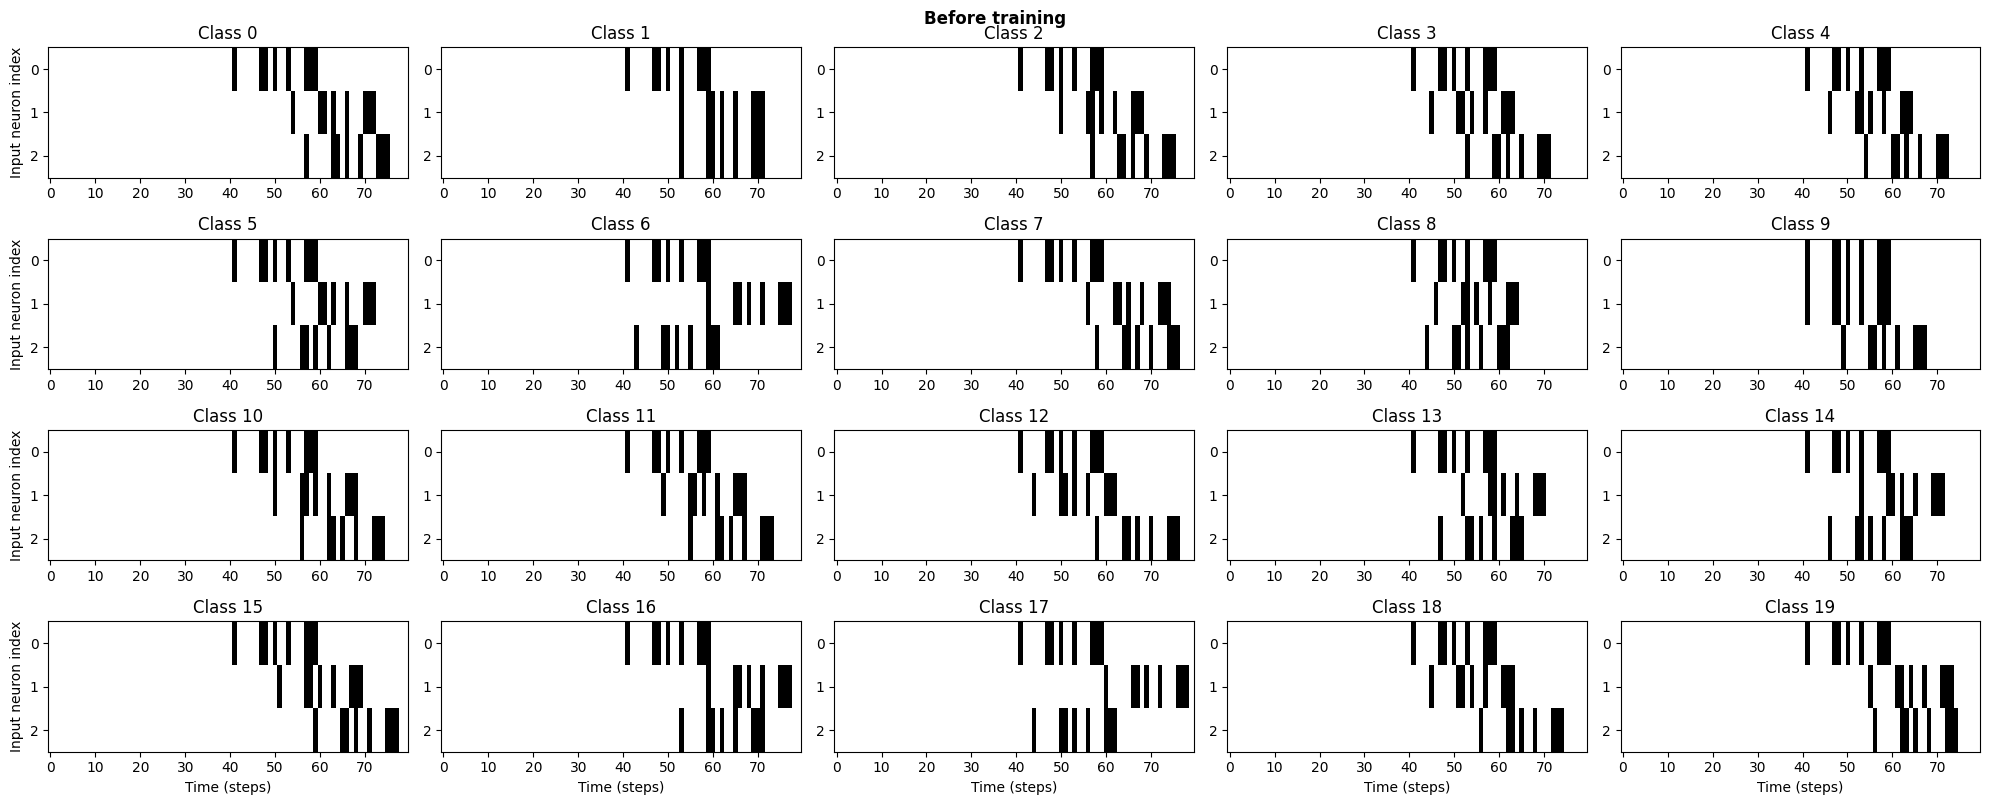

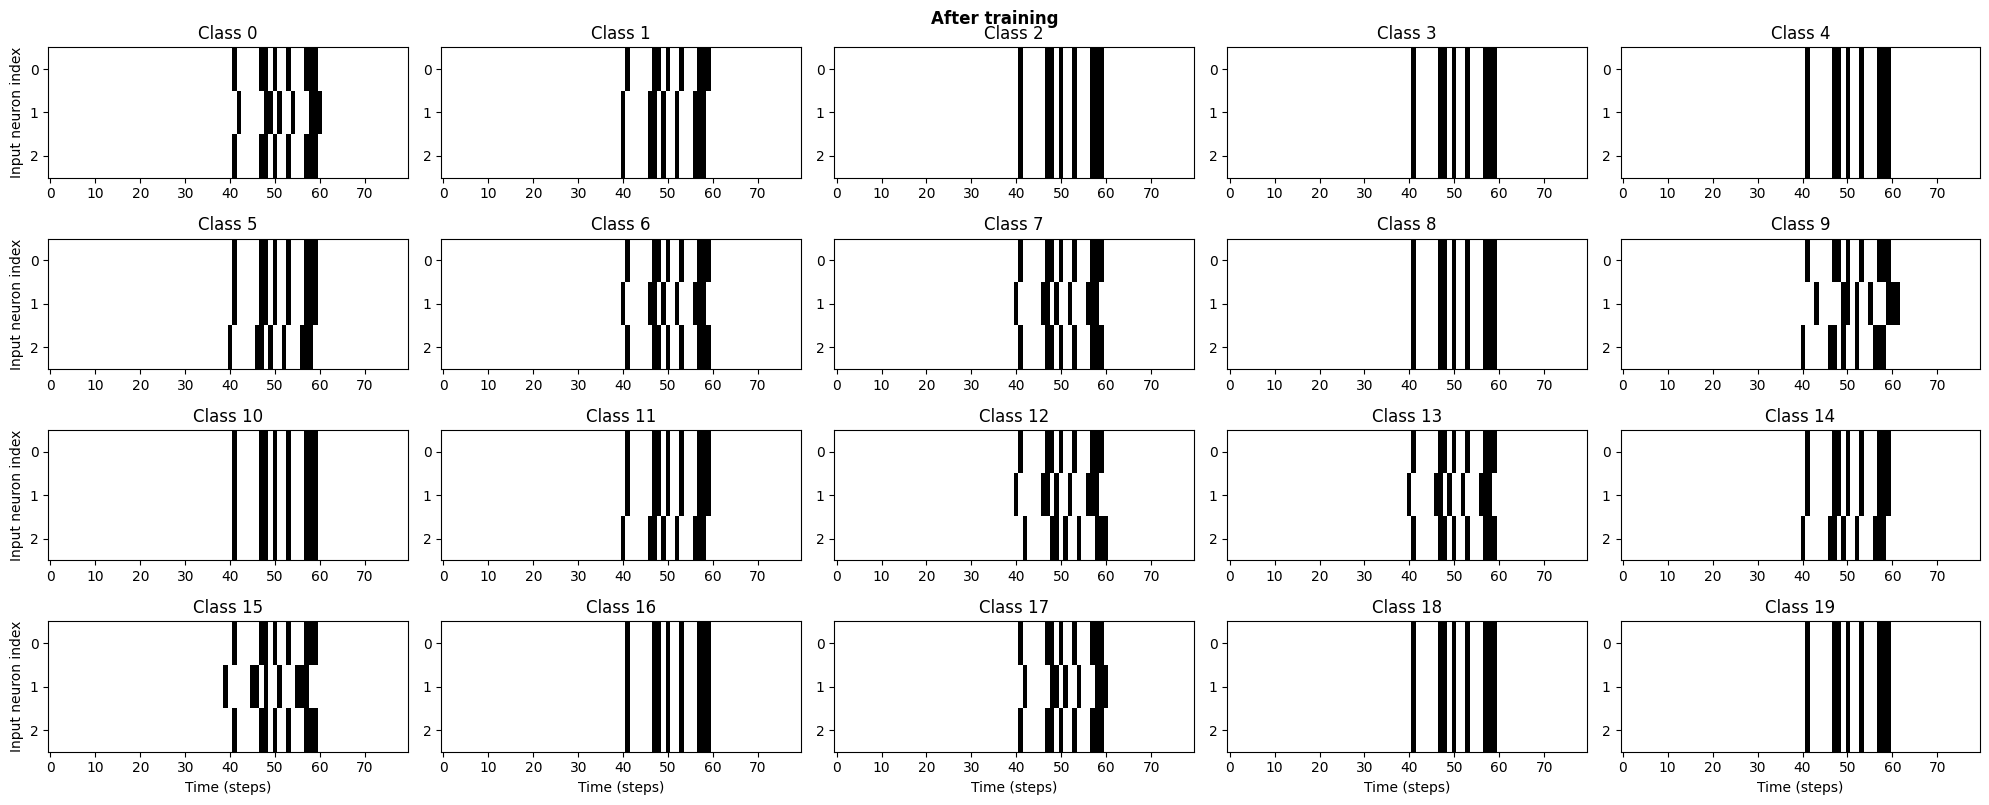

In [9]:
#@title Training routine
def training_loop(minimum_loss = 0.000001):
    for e in range(NB_EPOCHS):
        local_loss = []
        for x_local, y_local in get_batch():
            # Apply the delays only to the input spikes
            output = snn(x_local)

            # Get the corresponding targets from the batch
            target = []
            for i in range(BATCH_SIZE):
                target.append(np.where(y_local[i] > 0.5))
            target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)

            # A chessy loss function to calculate the maximum per output and set the maximum as the target.
            # The idea is to learn the delays the maximizes the output of the multiplicative synapses.
            max_sum = torch.amax(output, dim=1).detach()
            # max_sum = 1.01*max_sum
            for j in range(BATCH_SIZE):
                index = target[j].item()
                if TAU_DECAY_FLAG:
                    MAX_SUM[index] = max_sum[j]
                else:
                    if MAX_SUM[index] < max_sum[j]:
                        MAX_SUM[index] = max_sum[j]

            loss = 0
            for j in range(BATCH_SIZE):
                index = target[j].item()
                loss_single = (output[j, index] - MAX_SUM[index]) ** 2 / BATCH_SIZE
                loss += loss_single

            # out_prop = log_softmax_fn(output)
            # loss = loss_fn(out_prop, target)

            local_loss.append(loss.item())
            optimizer_delay_apply.zero_grad()
            loss.backward()
            optimizer_delay_apply.step()
            """"""

        if TAU_DECAY_FLAG:
            TAU *= np.exp(-TAU_DECAY)
        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        # print('Applied delays clamped: ', torch.round(torch.clamp(delay_layer.delays_out.flatten(),
        #                                             min=-delay_layer.max_delay, max=delay_layer.max_delay)), '\n\n\n\n\n')
        # Visualization of the effect of delays on the input patterns
        if np.mean(local_loss) < minimum_loss:
            trial_input_all = []
            for i in range(NUMBER_CLASSES):
                trial_input_all.append(input_targets_all[i][0])
            trial_input_all = np.array(trial_input_all)
            trial_input = torch.FloatTensor(trial_input_all.copy())
            trial_out = delay_layer.forward(trial_input).detach()
            fig_1, axs_1 = plt.subplots(4, 5, figsize=(20, 8), dpi=100)
            for i, ax in enumerate(axs_1.flat):
                if SHOW_IMAGE:
                    ax.imshow(np.concatenate((trial_input[i, 0, :, :], trial_input[i, 1, :, :])), aspect='auto',
                            interpolation='nearest', cmap=plt.cm.gray_r)
                else:
                    ax.imshow(trial_input[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
                ax.set_title(f'Class {i}')
                if i >= 15:
                    ax.set(xlabel='Time (steps)')
                if i % 5 == 0:
                    ax.set(ylabel='Input neuron index')
            fig_1.suptitle('Before training', fontweight="bold", x=0.5, y=1.0)
            plt.tight_layout()
            plt.show()
            print('\n\n\n\n\n\n\n')
            fig_2, axs_2 = plt.subplots(4, 5, figsize=(20, 8), dpi=100)
            for i, ax in enumerate(axs_2.flat):
                if SHOW_IMAGE:
                    ax.imshow(np.concatenate((trial_out[i, 0, :, :], trial_out[i, 1, :, :])), aspect='auto',
                            interpolation='nearest', cmap=plt.cm.gray_r)
                else:
                  ax.imshow(trial_out[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
                ax.set_title(f'Class {i}')
                if i >= 15:
                    ax.set(xlabel='Time (steps)')
                if i % 5 == 0:
                    ax.set(ylabel='Input neuron index')
            fig_2.suptitle('After training', fontweight="bold", x=0.5, y=1.0)
            plt.tight_layout()
            plt.show()
            break

training_loop()


Epoch 1: loss=4623.93945
Epoch 2: loss=56.18170
Epoch 3: loss=38.36674
Epoch 4: loss=26.82403
Epoch 5: loss=18.32592
Epoch 6: loss=15.34432
Epoch 7: loss=13.53976
Epoch 8: loss=9.37796
Epoch 9: loss=6.84598
Epoch 10: loss=5.25477
Epoch 11: loss=6.19171
Epoch 12: loss=5.20127
Epoch 13: loss=5.30573
Epoch 14: loss=5.39644
Epoch 15: loss=5.34032
Epoch 16: loss=4.27515
Epoch 17: loss=3.60774
Epoch 18: loss=3.83571
Epoch 19: loss=3.84651
Epoch 20: loss=3.61390
Epoch 21: loss=3.16746
Epoch 22: loss=3.70379
Epoch 23: loss=3.73798
Epoch 24: loss=3.06282
Epoch 25: loss=3.05730
Epoch 26: loss=3.27841
Epoch 27: loss=3.03782
Epoch 28: loss=2.96965
Epoch 29: loss=1.51395
Epoch 30: loss=1.37212
Epoch 31: loss=1.30885
Epoch 32: loss=0.95687
Epoch 33: loss=1.00516
Epoch 34: loss=0.89970
Epoch 35: loss=0.80429
Epoch 36: loss=0.91749
Epoch 37: loss=0.85631
Epoch 38: loss=0.93246
Epoch 39: loss=1.04576
Epoch 40: loss=0.94055
Epoch 41: loss=0.86712
Epoch 42: loss=0.95459
Epoch 43: loss=1.09050
Epoch 44: l

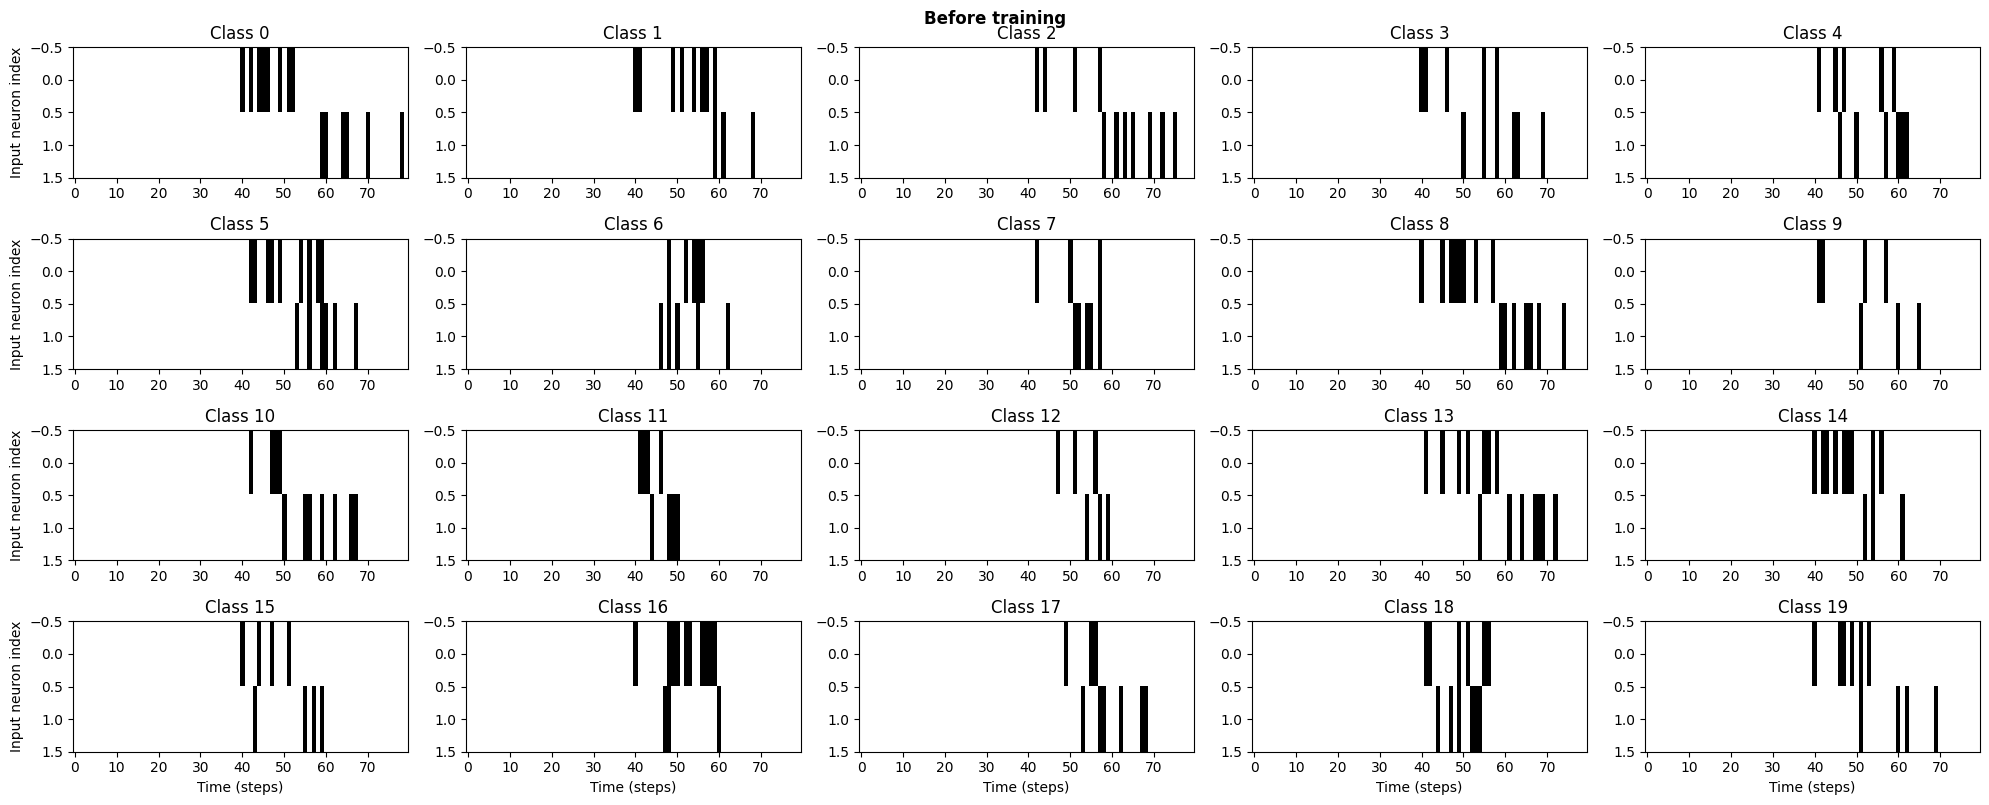

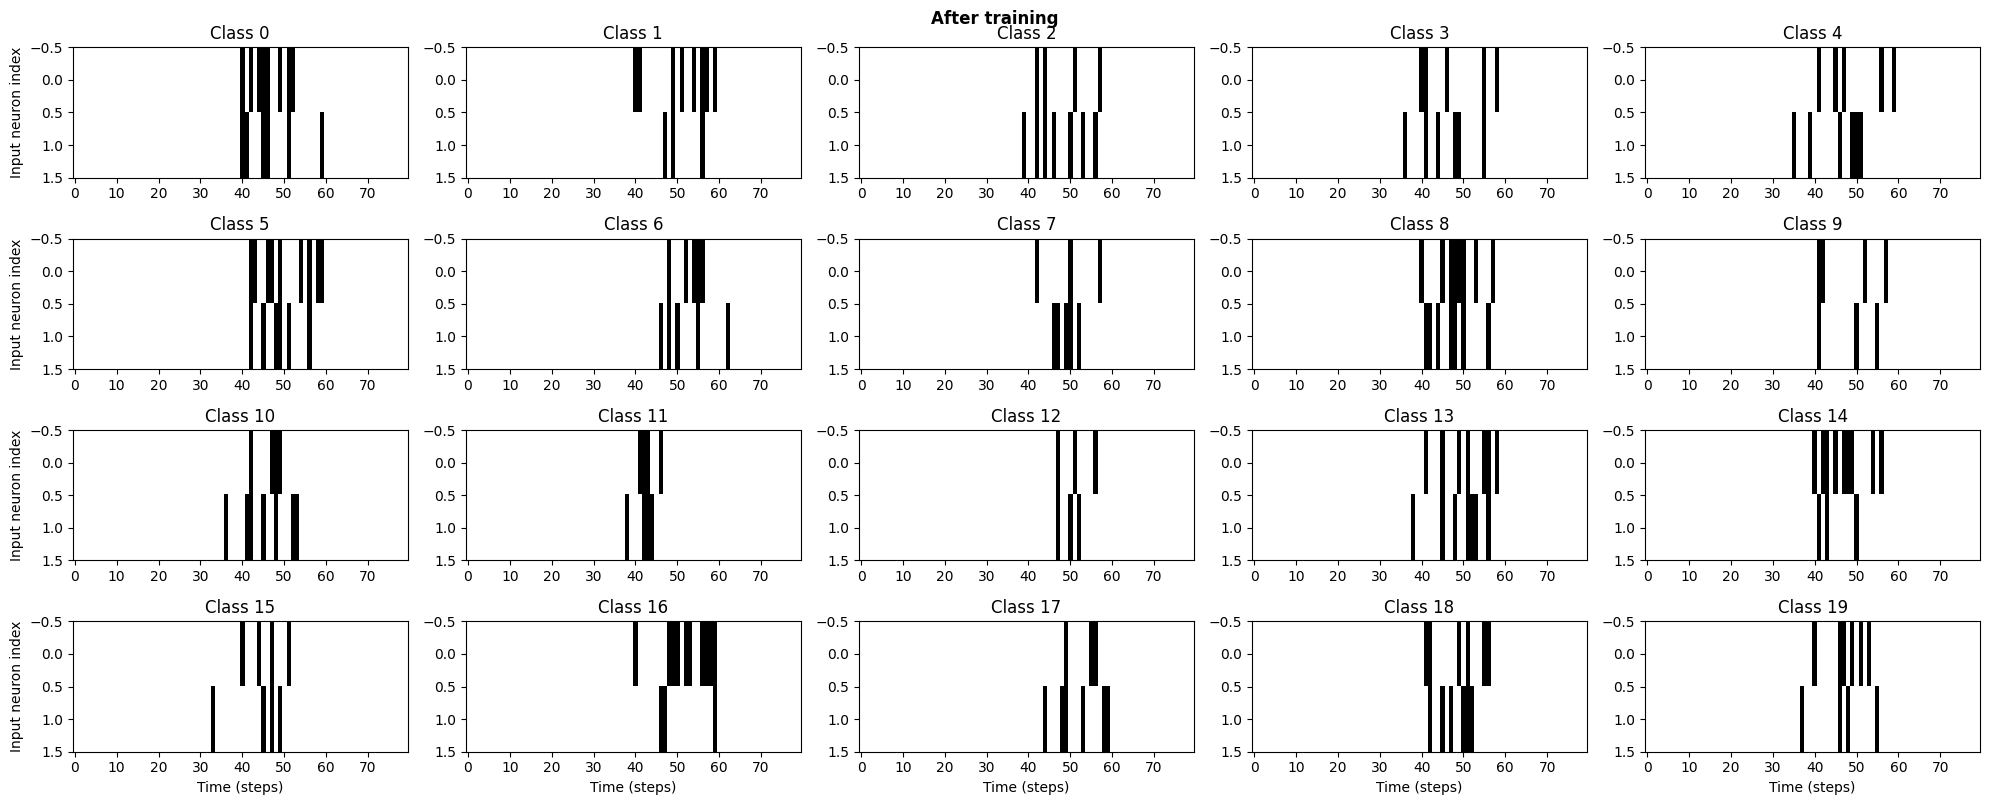

In [10]:
#@title Another example with different input patterns
SAME_PATTERN = False
NUMBER_INPUTS = 2
TAU = 30
INPUT_PATTERN = np.random.choice([0, 1], size=(NUMBER_INPUTS, NUMBER_CLASSES, DURATION_TRUE),
                                 p=[1-PROP_ONES, PROP_ONES])
MAX_SUM = np.zeros((NUMBER_CLASSES,))
input_targets_all = create_input_targets(duration=DURATION_TRUE, number_inputs=NUMBER_INPUTS,
                                         classes=NUMBER_CLASSES, duration_zeros=DURATION_ZEROS)
delay_layer = DelayLayer(lr_delay=0.2, constant_delays=False, constant_value=19)
optimizer_delay_apply = delay_layer.optimizer_delay
loss_hist = []
training_loop(minimum_loss = 0.03)


The most important parameters for training are the TAU, TAU_DECAY and the learning rate. The TAU_DECAY effect is not yet optimized and needs further investigations. The synaptic integration function is based on multiplicative interaction (non-linear) at the distal dendrites and then summation at the soma.

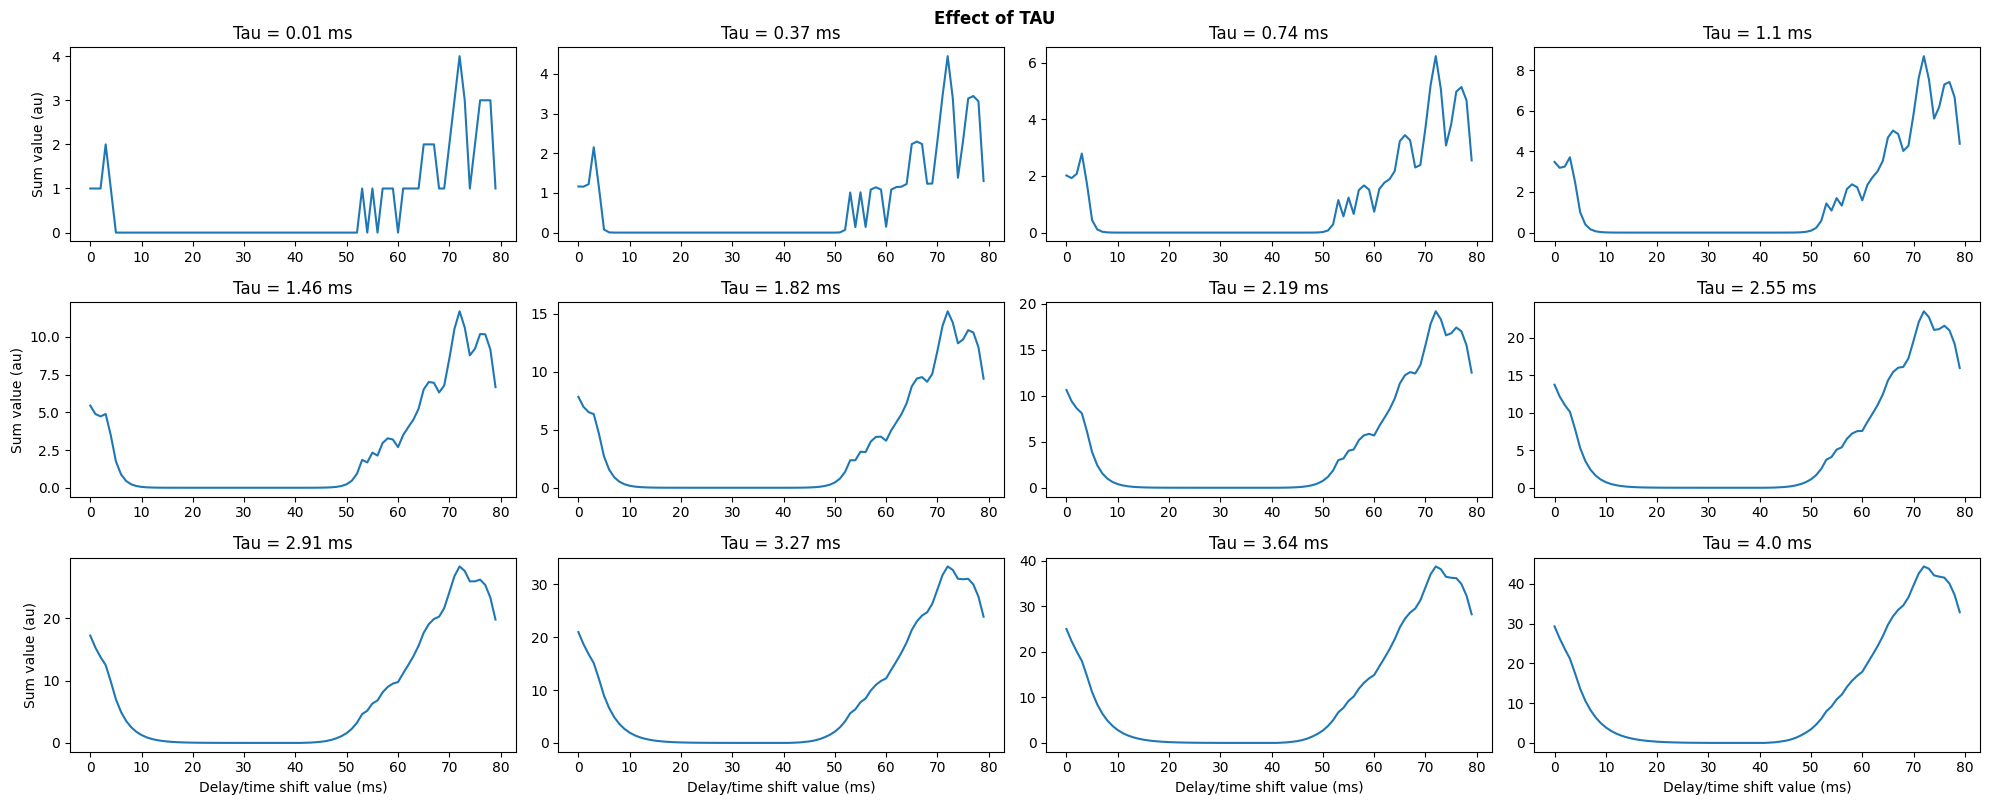

In [11]:
#@title Effect of TAU
out = next(get_batch())
_ = snn(out[0], normal=False)

As been seen from the above examples, the delay learning problem is a non convex optimization, when 1) we try to learn dealys in one layer, and 2) use the above loss and synaptic integration function. Non-convex optimization is tricky and there is a whole field in ML for non-convex optimization. Increasing TAU for the above cases leads to a smoother function, but also leads to a misallignement of the spikes. TAU_DECAY should help zoom in on a better spike alignment. 

# Simplified sound localization problem with one delay layer

Here, we will try to learn ipds with a single delay layer. However, in contrast to the original example, the input patterns are fixed during training. Stochastic input leads to stochastic output. The best loss function for stochastic output is the cross entropy loss. Sadly, it is difficult to learn delays with this loss function. I don't know exactly why, but I believe it has to do with the fact that the output of the softmax has all delay layers parameters into consideration. Thus, while one tries to optimize a specific delay for a spike train, one also un-optimize the other delays. 

In [17]:
#@title Relevant definitions
torch.set_printoptions(precision=8, sci_mode=False, linewidth=200)
np.set_printoptions(precision=10, suppress=True)
np.random.seed(0)
torch.manual_seed(0)

# Not using Brian so we just use these constants to make equations look nicer below
SECOND = 1
MS = 1e-3
HZ = 1
# Stimulus and simulation parameters
DT = 1 * MS            # large time step to make simulations run faster for tutorial
ANF_PER_EAR = 100    # repeats of each ear with independent noise  # number of classes
ENVELOPE_POWER = 10   # higher values make sharper envelopes, easier
RATE_MAX = 600 * HZ   # maximum Poisson firing rate
F = 50 * HZ            # stimulus frequency
DURATION = 50 * MS  # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
ANG_STEP = 5
NUMBER_CLASSES = int(180/ANG_STEP)
# Training parameters
NB_EPOCHS = 2000  # quick, it won't have converged
BATCH_SIZE = 200
N_TRAINING_BATCHES = 64
N_TESTING_BATCHES = 32
device = device = torch.device("cpu")
"""Delay paramters and functions"""
MAX_DELAY = 20  # Assumed to be in ms
MAX_DELAY_DURATION = MAX_DELAY
NUM_EAR = 2    
NUMBER_INPUTS = NUM_EAR
LR_DELAY = 0.05
EFFECTIVE_DURATION = MAX_DELAY * 3 + int(np.round(DURATION / DT))
TAU, TAU_DECAY, TAU_DECAY_FLAG = 40, 0.01, True
ROUND_DECIMALS = 4
MAX_SUM = np.zeros((BATCH_SIZE,))
FIX_FIRST_INPUT = True
SHOW_IMAGE = False
ALL_RANDOM = 1

In [18]:
#@title Input target generators
torch.set_printoptions(precision=8, sci_mode=False, linewidth=200)
np.set_printoptions(precision=10, suppress=True)
np.random.seed(0)
torch.manual_seed(0)

def input_signal():
    ipds_ang = np.arange(-90, 90, ANG_STEP)
    ipds_hot = np.zeros((NUMBER_CLASSES, NUMBER_CLASSES))
    for idx in range(NUMBER_CLASSES):
        ipds_hot[idx, idx] = 1
    ipds_rad = ipds_ang*np.pi/180
    num_classes = len(ipds_ang)
    time_axis = np.arange(DURATION_STEPS) * DT  # array of times
    phi = 2*np.pi*(F * time_axis + np.random.rand())  # array of phases corresponding to those times with random offset
    phi = 2 * np.pi * (F * time_axis)  # array of phases corresponding to those times with random offset

    theta = np.zeros((num_classes, NUM_EAR, num_classes, DURATION_STEPS))
    zeros_pad = np.zeros((num_classes, NUM_EAR, num_classes, MAX_DELAY_DURATION))
    theta[:, 0, :, :] = phi[np.newaxis, np.newaxis, :]
    theta[:, 1, :, :] = phi[np.newaxis, np.newaxis, :] + ipds_rad[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes_out = np.random.rand(num_classes, NUM_EAR, num_classes, DURATION_STEPS) < RATE_MAX * \
        DT * (0.5 * (1 + np.sin(theta))) ** ENVELOPE_POWER
    spikes_out = np.concatenate((zeros_pad, spikes_out, zeros_pad, zeros_pad), axis=3)
    return spikes_out, ipds_hot


def input_signal_2():
    ipds_ang = np.arange(-90, 90, ANG_STEP)
    ipds_hot = np.zeros((NUMBER_CLASSES, NUMBER_CLASSES))
    for idx in range(NUMBER_CLASSES):
        ipds_hot[idx, idx] = 1
    ipds_rad = ipds_ang*np.pi/180
    num_classes = len(ipds_ang)
    time_axis = np.arange(DURATION_STEPS) * DT  # array of times
    phi = 2*np.pi*(F * time_axis + np.random.rand())  # array of phases corresponding to those times with random offset
    phi = 2 * np.pi * (F * time_axis + np.random.rand())

    theta = np.zeros((num_classes, NUM_EAR, DURATION_STEPS))
    zeros_pad = np.zeros((num_classes, NUM_EAR, MAX_DELAY_DURATION))
    theta[:, 0, :] = phi[np.newaxis, np.newaxis, :]
    theta[:, 1, :] = phi[np.newaxis, np.newaxis, :] + ipds_rad[np.newaxis, :, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes_out = np.random.rand(num_classes, NUM_EAR, DURATION_STEPS) < RATE_MAX * \
        DT * (0.5 * (1 + np.sin(theta))) ** ENVELOPE_POWER
    spikes_out = np.concatenate((zeros_pad, spikes_out, zeros_pad, zeros_pad), axis=2)
    spikes_temp = np.zeros((num_classes, NUM_EAR, num_classes, EFFECTIVE_DURATION))
    spikes_one = spikes_out[:, 0, :]
    spikes_two = spikes_out[:, 1, :]
    spikes_temp[:, 0, :, :] = spikes_one
    spikes_temp[:, 1, :, :] = spikes_two
    spikes_out = spikes_temp.copy()
    spikes_out = np.swapaxes(spikes_out, 0, 2)
    return spikes_out, ipds_hot


def input_signal_3(ipd_choice=0):
    ipds_hot = np.zeros((NUMBER_CLASSES,))
    ipds_hot[ipd_choice] = 1
    ipds_rad = ipd_choice*np.pi/180
    time_axis = np.arange(DURATION_STEPS) * DT  # array of times
    phi = 2*np.pi*(F * time_axis + np.random.rand())  # array of phases corresponding to those times with random offset

    theta = np.zeros((NUM_EAR, DURATION_STEPS))
    zeros_pad = np.zeros((NUM_EAR, MAX_DELAY_DURATION))
    theta[0, :] = phi[np.newaxis, :]
    theta[1, :] = phi[np.newaxis, :] + ipds_rad
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes_temp = np.random.rand(NUM_EAR, DURATION_STEPS) < RATE_MAX * \
        DT * (0.5 * (1 + np.sin(theta))) ** ENVELOPE_POWER
    spikes_temp = np.concatenate((zeros_pad, spikes_temp, zeros_pad, zeros_pad), axis=1)
    spikes_out = np.zeros((NUM_EAR, NUMBER_CLASSES, EFFECTIVE_DURATION))
    spikes_out[:, :, :] = spikes_temp[:, np.newaxis, :]
    return spikes_out, ipds_hot

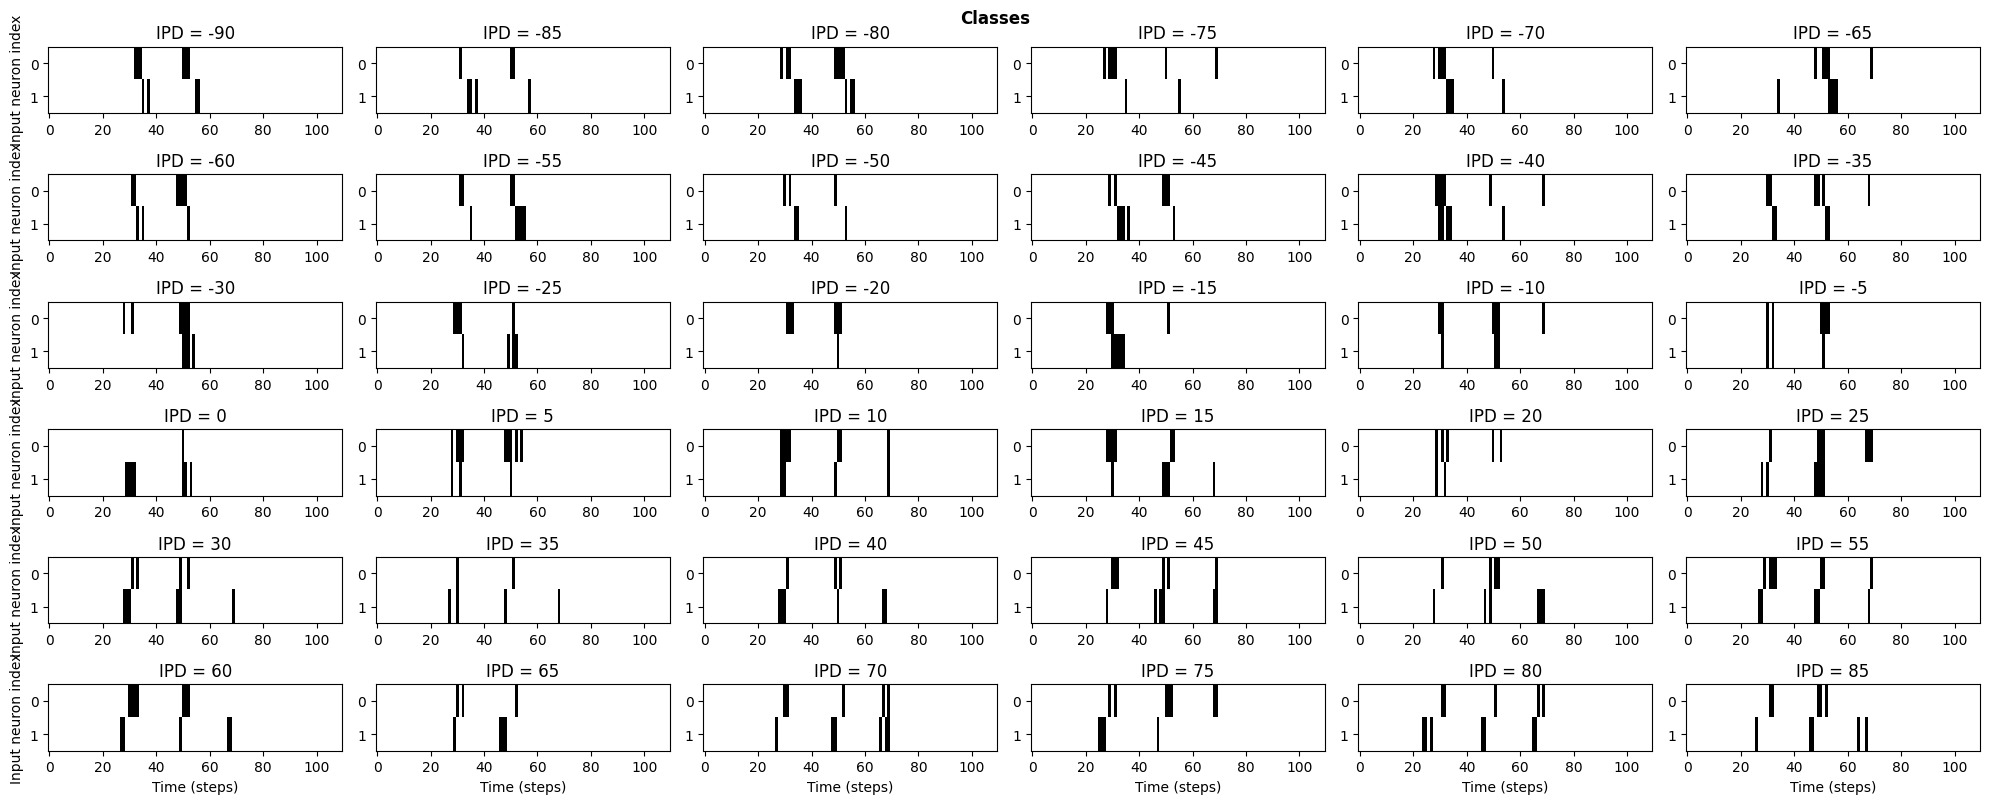

In [19]:
#@title Batch generator function and related
torch.set_printoptions(precision=8, sci_mode=False, linewidth=200)
np.set_printoptions(precision=10, suppress=True)
np.random.seed(0)
torch.manual_seed(0)

if ALL_RANDOM == 0:
    spikes_out_all, ipds_hot_all = input_signal()
elif ALL_RANDOM == 1:
    spikes_out_all, ipds_hot_all = input_signal_2()
else:
    spikes_out_all, ipds_hot_all = input_signal_3()

def generate_input_targets(spikes_in=0, ipds_in=0, n=NUMBER_CLASSES):
    while True:
        choice = np.random.choice(n)
        if ALL_RANDOM == 0 or ALL_RANDOM == 1:
            yield spikes_in[choice], ipds_in[choice]
        else:
            yield input_signal_3(ipd_choice=choice)

fig, axs = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
ipds_range = np.arange(-90, 90, ANG_STEP)
for i, ax in enumerate(axs.flat):
    if SHOW_IMAGE:
        ax.imshow(np.concatenate((spikes_out_all[i, 0, :, :], spikes_out_all[i, 1, :, :])), aspect='auto',
                  interpolation='nearest', cmap=plt.cm.gray_r)
    else:
        ax.imshow(spikes_out_all[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    ax.set_title(f'IPD = {ipds_range[i]}')
    if i >= 30:
        ax.set(xlabel='Time (steps)')
    if i % 6 == 0:
        ax.set(ylabel='Input neuron index')
fig.suptitle('Classes', fontweight="bold", x=0.5, y=1.0)
plt.tight_layout()
plt.show()
def get_batch():
    inputs, targets = [], []
    for _ in range(BATCH_SIZE):
        if ALL_RANDOM == 0 or ALL_RANDOM == 1:
            value = next(generate_input_targets(spikes_in=spikes_out_all, ipds_in=ipds_hot_all))
            inputs.append(value[0])
            targets.append(value[1])
        else:
            value_input, value_target = next(generate_input_targets())
            inputs.append(value_input)
            targets.append(value_target)
    yield torch.Tensor(np.array(inputs)), torch.Tensor(np.array(targets))

In [20]:
#@title Synaptic integration for the sound localization problem
np.random.seed(0)
torch.manual_seed(0)

def snn_sl(input_spikes):
    input_spikes = delay_layer(input_spikes)
    duration_in = delay_layer.effective_duration
    """"""
    v = torch.zeros((BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    input_spikes_add = torch.sum(input_spikes, dim=1)
    alpha = np.exp(-1 / TAU)
    for t in range(duration_in - 1):
        v[:, :, :, t] = alpha * v[:, :, :, t-1] + input_spikes[:, :, :, t]

    first_mat = v[:, 1:, :, :]
    v_mul = torch.mul(first_mat, v[:, 0:1, :, :])
    v_out = v_mul
    v_out = torch.sum(v_out, dim=1)
    v_out = torch.sum(v_out, dim=2)
    return v_out

Epoch 1: loss=1353.12097
Tau:  39.601993349966726
Epoch 2: loss=385.64023
Tau:  39.20794693227022
Epoch 3: loss=162.11420
Tau:  38.81782134194034
Epoch 4: loss=150.11247
Tau:  38.43157756609294
Epoch 5: loss=114.06781
Tau:  38.04917698002858
Epoch 6: loss=92.72813
Tau:  37.67058134336997
Epoch 7: loss=63.33299
Tau:  37.29575279623795
Epoch 8: loss=61.49543
Tau:  36.92465385546545
Epoch 9: loss=59.54112
Tau:  36.55724741084915
Epoch 10: loss=41.32266
Tau:  36.19349672143841
Epoch 11: loss=48.68990
Tau:  35.83336541186116
Epoch 12: loss=37.05945
Tau:  35.476817468686335
Epoch 13: loss=35.99608
Tau:  35.12381723682249
Epoch 14: loss=38.08598
Tau:  34.77432941595227
Epoch 15: loss=28.23213
Tau:  34.428319057002355
Epoch 16: loss=31.54223
Tau:  34.0857515586485
Epoch 17: loss=26.88283
Tau:  33.74659266385539
Epoch 18: loss=21.90092
Tau:  33.41080845645092
Epoch 19: loss=15.48784
Tau:  33.07836535773453
Epoch 20: loss=18.45501
Tau:  32.74923012311932
Epoch 21: loss=17.40580
Tau:  32.42336983

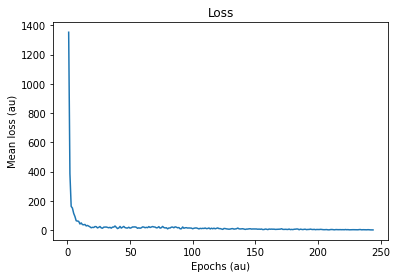

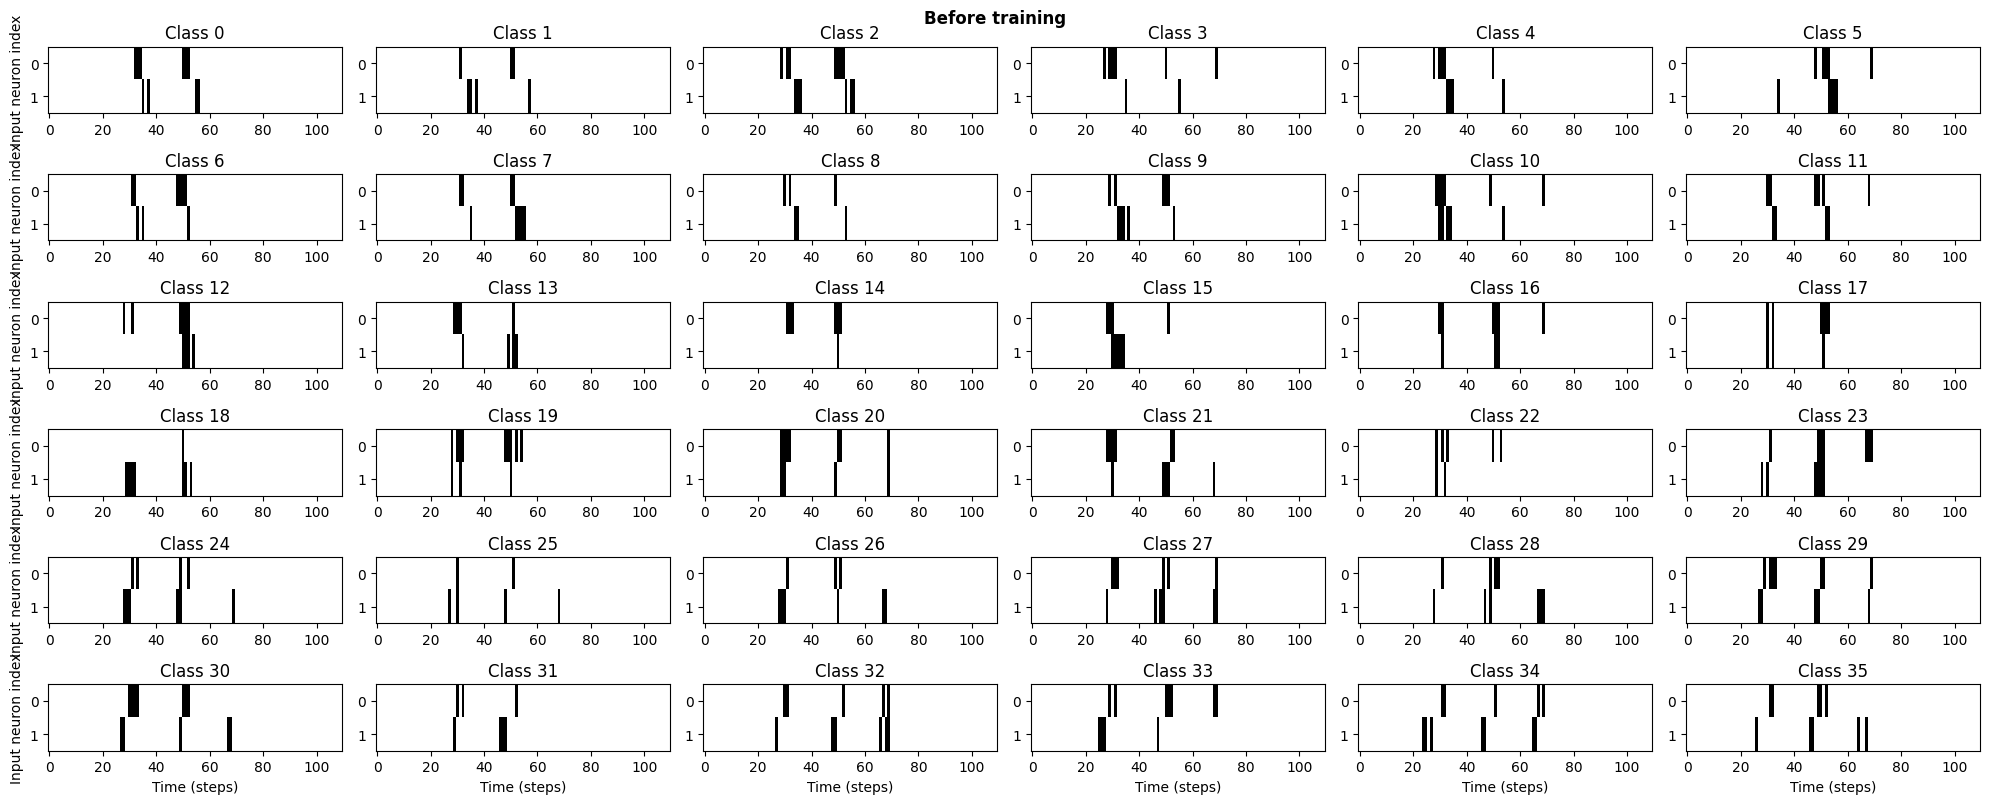

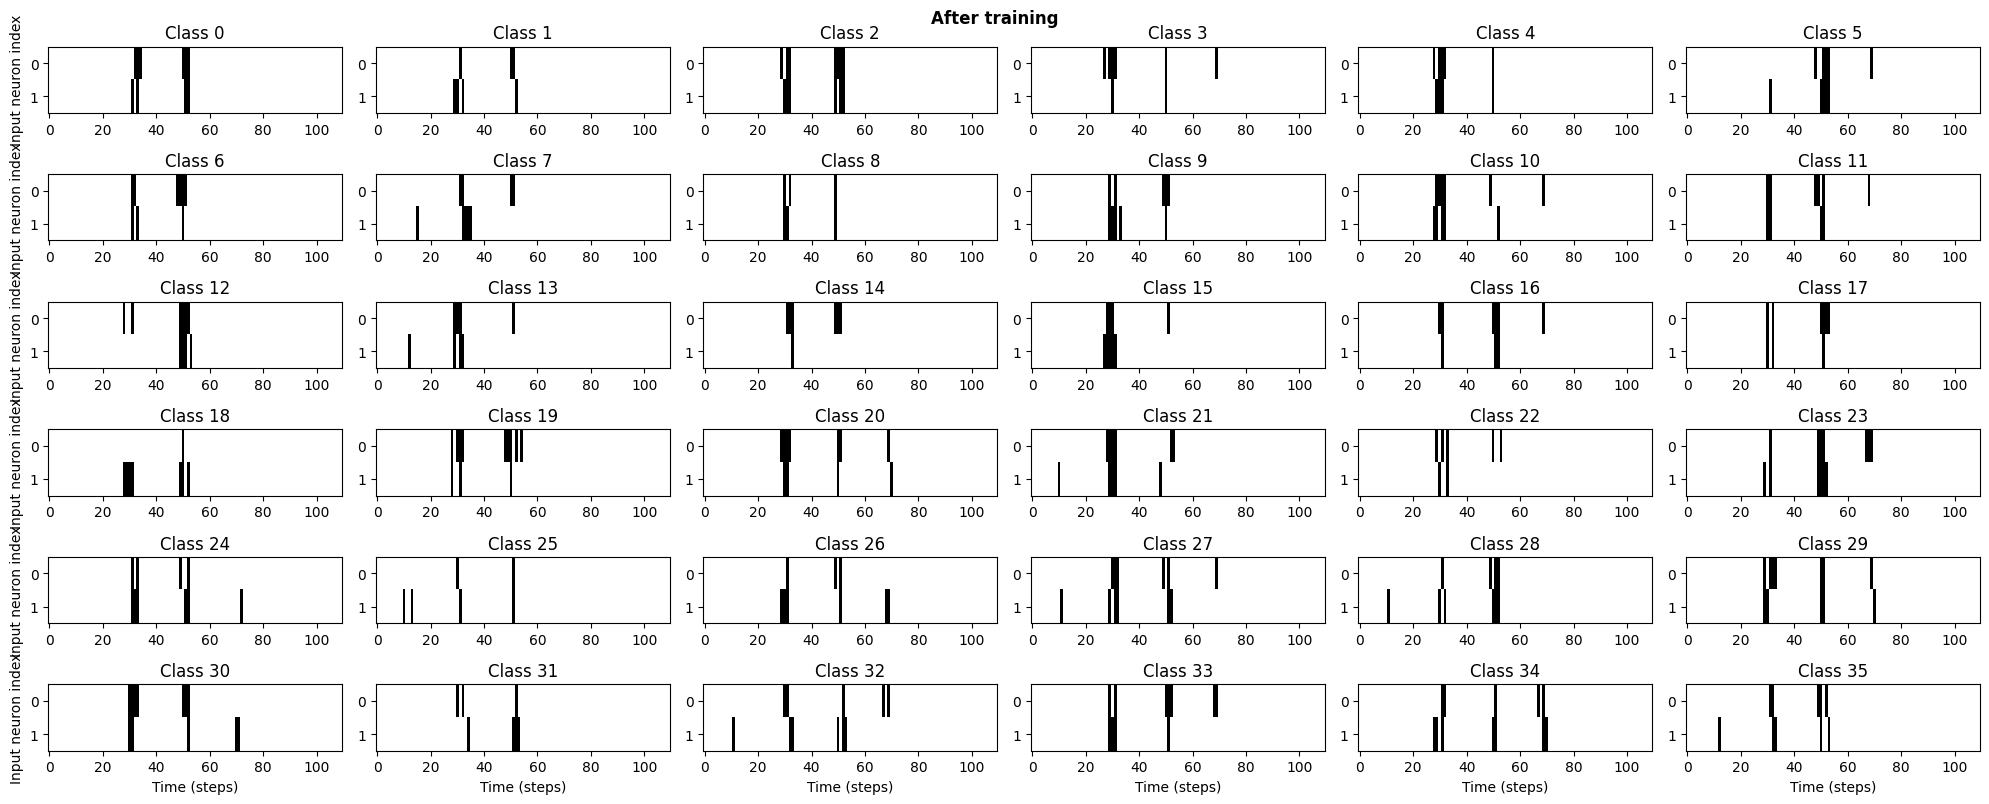

In [21]:
#@title Training loop and parameters
np.random.seed(0)
torch.manual_seed(0)
delay_layer = DelayLayer(lr_delay=0.5, constant_delays=False, constant_value=0, max_delay_in=MAX_DELAY)
delay_fn = DelayUpdate.apply
optimizer_delay_apply = delay_layer.optimizer_delay
loss_hist = []
max_sum_holder = np.zeros((NUMBER_CLASSES,))

for e in range(NB_EPOCHS):
    local_loss = []
    for x_local, y_local in get_batch():
        # Run network
        """Delay related update"""
        # Apply the delays only to the input spikes
        output = snn_sl(x_local)
        # print('Max: ', torch.amax(output_snn))
        max_sum = torch.amax(output, dim=1).detach()
        # max_sum = 1.01*max_sum

        target = []
        for i in range(BATCH_SIZE):
            target.append(np.where(y_local[i] > 0.5))
        target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)

        sum_counter = np.zeros((NUMBER_CLASSES,))
        for j in range(BATCH_SIZE):
            index = target[j].item()
            if ALL_RANDOM == 0 or ALL_RANDOM == 1:
                if TAU_DECAY_FLAG:
                    MAX_SUM[index] = max_sum[j]
                else:
                    if MAX_SUM[index] < max_sum[j]:
                        MAX_SUM[index] = max_sum[j]
            else:
                sum_counter[index] += 1
                MAX_SUM[index] += max_sum[j]

        if ALL_RANDOM == 2:
            for k in range(NUMBER_CLASSES):
                MAX_SUM[k] /= sum_counter[k]
                max_sum_holder[k] += MAX_SUM[k]

        """"""

        loss = 0
        for j in range(BATCH_SIZE):
            index = target[j].item()
            if ALL_RANDOM == 0 or ALL_RANDOM == 1:
                loss_single = (output[j, index] - MAX_SUM[index]) ** 2 / BATCH_SIZE
            else:
                loss_single = (output[j, index] - max_sum_holder[index]/(e+1)) ** 2 / BATCH_SIZE
            loss += loss_single

        local_loss.append(loss.item())
        optimizer_delay_apply.zero_grad()
        loss.backward()
        optimizer_delay_apply.step()
        """"""

    if TAU_DECAY_FLAG:
        if TAU >= 2:
            TAU *= np.exp(-TAU_DECAY)
        else:
          TAU = 2
        # print('Tau:', TAU)
    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
    print('Tau: ', TAU)
    # print('Actual delays clamped: ', torch.round(torch.clamp(delay_layer.delays_out.flatten(),
    #                                              min=-delay_layer.max_delay, max=delay_layer.max_delay)), '\n\n\n\n\n')
    # if e >= 10:
    if np.mean(local_loss) < 1:
        plt.plot(np.arange(1, e+2, 1), loss_hist)
        plt.title('Loss')
        plt.xlabel('Epochs (au)')
        plt.ylabel('Mean loss (au)')
        plt.show()
        print('\n\n\n\n\n')

        trial_input_all = spikes_out_all.copy()
        trial_input = torch.FloatTensor(trial_input_all.copy())
        trial_out = delay_layer.forward(trial_input).detach()
        fig_1, axs_1 = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs_1.flat):
            if SHOW_IMAGE:
                ax.imshow(np.concatenate((trial_input[i, 0, :, :], trial_input[i, 1, :, :])), aspect='auto',
                          interpolation='nearest', cmap=plt.cm.gray_r)
            else:
                ax.imshow(trial_input[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'Class {i}')
            if i >= 30:
                ax.set(xlabel='Time (steps)')
            if i % 6 == 0:
                ax.set(ylabel='Input neuron index')
        fig_1.suptitle('Before training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        fig_2, axs_2 = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs_2.flat):
            if SHOW_IMAGE:
                ax.imshow(np.concatenate((trial_out[i, 0, :, :], trial_out[i, 1, :, :])), aspect='auto',
                          interpolation='nearest', cmap=plt.cm.gray_r)
            else:
                ax.imshow(trial_out[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'Class {i}')
            if i >= 30:
                ax.set(xlabel='Time (steps)')
            if i % 6 == 0:
                ax.set(ylabel='Input neuron index')
        fig_2.suptitle('After training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        plt.show()
        break


For 36 classes, one layer of differentiable delays and an un-optimized loss function: the performance isn't that good, so I will not focus much on visualization of performance metrics.

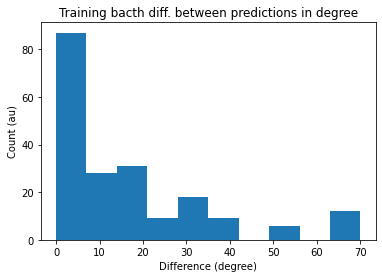

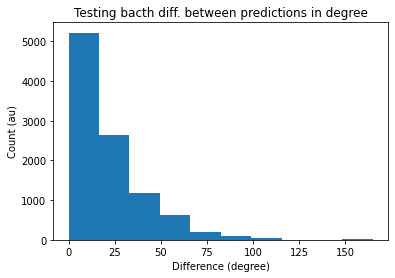

In [22]:
#@title Test performance
trial_count = 50
test_array = []
np.random.seed(0)
torch.manual_seed(0)

x_train, y_train = next(get_batch())
output = snn_sl(x_train)
max_index = torch.argmax(output, dim=1).detach().numpy()
target = []
for i in range(BATCH_SIZE):
    target.append(np.where(y_train[i] > 0.5))
target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)
diff_pred = torch.abs(target-max_index)

plt.hist(diff_pred*ANG_STEP)
plt.title('Training bacth diff. between predictions in degree')
plt.xlabel('Difference (degree)')
plt.ylabel('Count (au)')
plt.show()
print('\n\n')


for _ in range(trial_count):
    if ALL_RANDOM == 0:
        spikes_out_all, ipds_hot_all = input_signal()
    elif ALL_RANDOM == 1:
        spikes_out_all, ipds_hot_all = input_signal_2()
    else:
        spikes_out_all, ipds_hot_all = input_signal_3()
    x_test, y_test = next(get_batch())
    output = snn_sl(x_test)
    max_index = torch.argmax(output, dim=1).detach().numpy()
    target = []
    for i in range(BATCH_SIZE):
        target.append(np.where(y_test[i] > 0.5))
    target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)
    diff_pred = torch.abs(target-max_index)
    test_array.extend(list(diff_pred.detach().numpy()))
diff_pred = np.array(test_array)

plt.hist(diff_pred*ANG_STEP)
plt.title('Testing bacth diff. between predictions in degree')
plt.xlabel('Difference (degree)')
plt.ylabel('Count (au)')
plt.show()

In the next example, I will add an output layer with trainable weights and train with cross-entropy for the harder case where the input is dynamic.

In [23]:
#@title Relevant definitions

BETA_SPIKE = 5
OUT_SIZE = NUMBER_CLASSES
THRESHOLD = 0.5
TAU, TAU_DECAY, TAU_DECAY_FLAG = 5, 0.01, False
LR_WEIGHTS = 0.001
LR_DELAY = 20
ALL_RANDOM = 2

In [24]:
#@title Weight initialization
np.random.seed(0)
torch.manual_seed(0)

# Weights and uniform weight initialisation
def init_weight_matrix():
    W = nn.Parameter(torch.empty((NUMBER_CLASSES, OUT_SIZE), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

In [25]:
#@title Surrogate spike
np.random.seed(0)
torch.manual_seed(0)

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*BETA_SPIKE*torch.sigmoid(BETA_SPIKE*input)*(1-torch.sigmoid(BETA_SPIKE*input))
        return grad

In [26]:
#@title New synaptic integration function
np.random.seed(0)
torch.manual_seed(0)
batch_choice = 5

def snn_sl1(input_spikes):
    input_spikes = delay_layer(input_spikes)
    duration_in = delay_layer.effective_duration
    """"""
    v = torch.zeros((BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    vm = torch.zeros((BATCH_SIZE, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    v_rec = torch.zeros((BATCH_SIZE, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    input_spikes_add = torch.sum(input_spikes, dim=1)
    alpha = np.exp(-1 / TAU)
    for t in range(duration_in - 1):
        v[:, :, :, t] = (alpha * v[:, :, :, t-1] + input_spikes[:, :, :, t]) * (1-s[:, None, :, t-1])
        first_mat = v[:, 1:, :, t].clone()
        second_mat = v[:, 0:1, :, t].clone()
        vm[:, :, t] = torch.mul(first_mat, second_mat).squeeze()
        s[:, :, t] = spike_fn(vm[:, :, t]-THRESHOLD) 

    h = torch.einsum("abc,bd->adc", (s, WEIGHTS))
    for t in range(duration_in - 1):
        v_rec[:, :, t] = alpha * v_rec[:, :, t-1] + h[:, :, t]

    # v = v.detach().numpy()
    # v_image = np.concatenate((v[batch_choice, 0, :, :], v[batch_choice, 1, :, :]))
    # plt.imshow(v_image)
    # plt.colorbar()
    # plt.show()
    # vm = vm.detach().numpy()
    # plt.imshow(vm[batch_choice])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(s[batch_choice].detach().numpy())
    # plt.show()
    return v_rec

In [28]:
#@title Training loop
torch.autograd.set_detect_anomaly(True)
np.random.seed(0)
torch.manual_seed(0)

spike_fn  = SurrGradSpike.apply
WEIGHTS = init_weight_matrix()

delay_layer = DelayLayer(lr_delay=LR_DELAY, constant_delays=False, constant_value=0, max_delay_in=MAX_DELAY)
optimizer_delay_apply = delay_layer.optimizer_delay
delay_fn = DelayUpdate.apply
optimizer_weights = torch.optim.Adam([WEIGHTS], lr=LR_WEIGHTS)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(NB_EPOCHS):
    local_loss = []
    for x_local, y_local in get_batch():
      
        output = snn_sl1(x_local)
        output = torch.sum(output, dim=2)
        target = []
        for i in range(BATCH_SIZE):
            target.append(np.where(y_local[i] > 0.5))
        target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)

        loss = loss_fn(log_softmax_fn(output), target)
        local_loss.append(loss.item())
     
        optimizer_delay_apply.zero_grad()
        optimizer_weights.zero_grad()
        loss.backward()
        optimizer_delay_apply.step()
        optimizer_weights.step()
        """"""

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
    # print('Actual delays clamped: ', torch.round(torch.clamp(delay_layer.delays_out.flatten(),
    #                                              min=-delay_layer.max_delay, max=delay_layer.max_delay)), '\n\n\n\n\n')
    # if e >= 1:
    if (np.mean(local_loss) < 0.001) or (e > 50):
        break
        trial_input_all = spikes_out_all.copy()
        trial_input = torch.FloatTensor(trial_input_all.copy())
        trial_out = delay_layer.forward(trial_input).detach()
        fig_1, axs_1 = plt.subplots(3, 4, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs_1.flat):
            if SHOW_IMAGE:
                ax.imshow(np.concatenate((trial_input[i, 0, :, :], trial_input[i, 1, :, :])), aspect='auto',
                          interpolation='nearest', cmap=plt.cm.gray_r)
            else:
                ax.imshow(trial_input[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'Class {i}')
            if i >= 36:
                ax.set(xlabel='Time (steps)')
            if i % 9 == 0:
                ax.set(ylabel='Input neuron index')
        fig_1.suptitle('Before training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        fig_2, axs_2 = plt.subplots(3, 4, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs_2.flat):
            if SHOW_IMAGE:
                ax.imshow(np.concatenate((trial_out[i, 0, :, :], trial_out[i, 1, :, :])), aspect='auto',
                          interpolation='nearest', cmap=plt.cm.gray_r)
            else:
                ax.imshow(trial_out[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'Class {i}')
            if i >= 36:
                ax.set(xlabel='Time (steps)')
            if i % 9 == 0:
                ax.set(ylabel='Input neuron index')
        fig_2.suptitle('After training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        plt.show()
        

Epoch 1: loss=11.04266
Epoch 2: loss=9.53374
Epoch 3: loss=8.18771
Epoch 4: loss=8.53678
Epoch 5: loss=8.01341
Epoch 6: loss=7.82801
Epoch 7: loss=7.01900
Epoch 8: loss=5.98131
Epoch 9: loss=6.41223
Epoch 10: loss=6.03342
Epoch 11: loss=5.91816
Epoch 12: loss=5.73771
Epoch 13: loss=5.40665
Epoch 14: loss=5.90104
Epoch 15: loss=5.55983
Epoch 16: loss=5.55448
Epoch 17: loss=5.41602
Epoch 18: loss=5.02097
Epoch 19: loss=5.37294
Epoch 20: loss=5.28181
Epoch 21: loss=5.10512
Epoch 22: loss=4.73427
Epoch 23: loss=5.11504
Epoch 24: loss=5.02654
Epoch 25: loss=5.05402
Epoch 26: loss=4.87612
Epoch 27: loss=4.92842
Epoch 28: loss=4.91075
Epoch 29: loss=4.91004
Epoch 30: loss=4.60573
Epoch 31: loss=4.72401
Epoch 32: loss=4.45368
Epoch 33: loss=4.54074
Epoch 34: loss=4.62440
Epoch 35: loss=4.43938
Epoch 36: loss=4.39366
Epoch 37: loss=4.47433
Epoch 38: loss=4.50037
Epoch 39: loss=4.56359
Epoch 40: loss=4.44698
Epoch 41: loss=4.42153
Epoch 42: loss=4.36636
Epoch 43: loss=4.49143
Epoch 44: loss=4.39

Co-training of delays and weights still needs some work. I havn't had enough time, but I will try to focus on it from now on.

# Concept + little Brian implementation of a biologically plausible learning mechanism of delays

It should be noted outright that, as far as I know, delays can't be changed dynamically during runtime in Brian2. Regardless, I will show a concept with some code of how to learn delays. Also, delays can be introduced in brian via a multistage lagging variable. This idea is take from the book Spikes, Decisions and Actions by Wilson. 

It should be noted that delays for pattern matching or output maximization can be inferred from the maximum of the temporal convolution of two spike trains. However, knowing the maximum of a temporal convolution entitles knowing the future in a running spike train. In the following conceptual study, I will demonstrate how this can be bypassed. 

Biologically plausible concept for learning delays

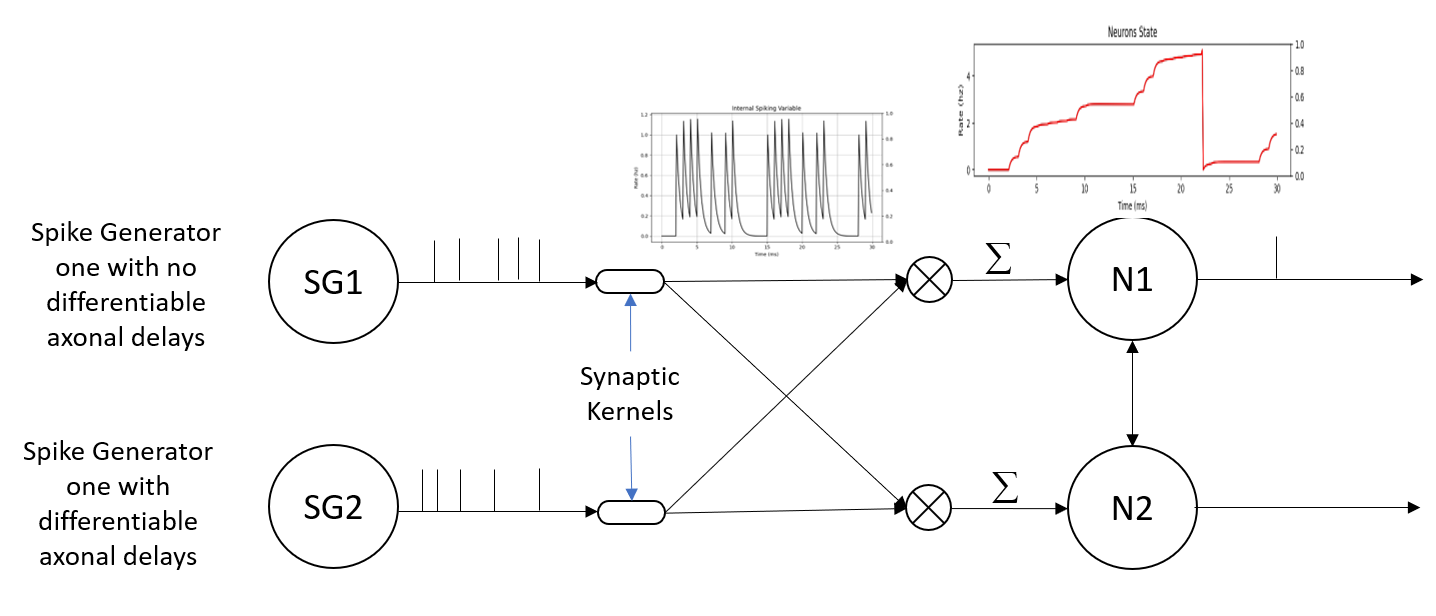

Here we have two spike generators SG1 and SG2. SG2 can have its axonal delays learned, while SG1 can't! The spike trains from both generators go through an exponentially decaying synaptic kernel as shown. Then, the outputs of the kernels are multiplied and summed at the soma as shown on the right figure. This happens for both neurons N1 and N2. The difference between N1 and N2 is the initial delay value from SG2 to them. Since, the delay is different for both neurons, one neuron while have a higher integrated input then the other. The neuron with the higher internal state will fire first and inhibit the other. While the other neuron is inhibited, it will signal SG2 to change the respective synaptic delay.

In [29]:
#@title Neuronal class and parameters

np.random.seed(0)
br.devices.device.seed(0)

class DelayLearning:
    def __init__(self):
        self.para = {'tau': 1000, 'delay_fixed': 1, 'th': 8, 'tau_th': 50, 'tau_ds1': 0, 'tau_ds2': 1}
        self.model_one = '''
        dv_1/dt = 1/(tau*ms) * (-v_1 + 2000*s_1*s_2) : 1
        ds_1/dt = -s_1/(0.5*ms) : 1 
        ds_2/dt = -s_2/(0.5*ms) : 1 
        dv_th1/dt = -v_th1/(tau_th*ms) : 1
        d_1 : second
        '''
        self.model_two = '''
        dv_2/dt = (1/(tau*ms)) * (-v_2 + 2000*s_1*s_2): 1
        ds_1/dt = -s_1/(0.5*ms) : 1 
        ds_2/dt = -s_2/(0.5*ms) : 1 
        dv_th2/dt = -v_th2/(tau_th*ms) : 1
        d_2 : second
        '''

In [30]:
#@title Relevant definitions

SEED = True
if SEED:
    np.random.seed(0)
    br.devices.device.seed(0)
SIMULATION_DURATION = 30 * br.ms  # Simulation time
NUM_NEURONS = (1, 1, 1, 1)  # Number of neurons for different neuronal model in a neural circuit
NEURON_MODELS = DelayLearning()
br.prefs.codegen.target = 'numpy'
LIST_PARA = list(NEURON_MODELS.para.keys())
LIST_VALUE = list(NEURON_MODELS.para.values())
DEFAULT_PARA = NEURON_MODELS.para.copy()
PARA_DIS_MAX = 5
PARA_DIS_MAX = np.amin([PARA_DIS_MAX, len(NEURON_MODELS.para)])
NEURON_GROUPS = {0: NEURON_MODELS.model_one, 1: NEURON_MODELS.model_two}

TIME_PERIOD = 10
TIME_EXTENSION = 3
REPETITION_TIMES = 80
PROP_ONES = 0.5
INPUT_PATTERN = np.random.choice([0, 1], size=(TIME_PERIOD,), p=[1-PROP_ONES, PROP_ONES])
INPUT_PATTERN = np.where(INPUT_PATTERN > 0.9)[0] + 1
SPIKE_TIMES = []
for idy in range(REPETITION_TIMES):
    SPIKE_TIMES.append(INPUT_PATTERN+(TIME_PERIOD+TIME_EXTENSION)*idy)
SPIKE_TIMES = np.array(SPIKE_TIMES).flatten() * br.ms

In [31]:
#@title Simulation run

np.random.seed(0)
br.devices.device.seed(0)
for k, v in NEURON_MODELS.para.items():
    exec("%s = %d" % (k, v))

delay_value = NEURON_MODELS.para['delay_fixed'] * br.ms
threshold_initial = NEURON_MODELS.para['th']
g_1 = br.SpikeGeneratorGroup(1, [0] * len(list(SPIKE_TIMES)), SPIKE_TIMES, dt=0.1 * br.ms)
g_2 = br.SpikeGeneratorGroup(1, [0] * len(list(SPIKE_TIMES)), SPIKE_TIMES, dt=0.1 * br.ms)
neuron_group_one = br.NeuronGroup(NUM_NEURONS[0], NEURON_GROUPS[0], dt=0.1 * br.ms, method='rk4',
                                  threshold='v_1 >= v_th1', reset='v_1 = 0')
neuron_group_two = br.NeuronGroup(NUM_NEURONS[1], NEURON_GROUPS[1], dt=0.1 * br.ms, method='rk4',
                                  threshold='v_2 >= v_th2', reset='v_2 = 0')
neuron_group_one.v_th1 = threshold_initial
neuron_group_two.v_th2 = threshold_initial
neuron_group_one.d_1 = 0*br.ms
neuron_group_two.d_2 = 1*br.ms

s_11 = br.Synapses(g_1, neuron_group_one, on_pre='s_1_post += 1', dt=0.1 * br.ms, delay=delay_value)
s_11.connect()
s_12 = br.Synapses(g_1, neuron_group_two, on_pre='s_1_post += 1', dt=0.1 * br.ms, delay=delay_value)
s_12.connect()
s_21 = br.Synapses(g_2, neuron_group_one, on_pre='''s_2_post += 1
                                    delay = d_1''', on_post='''v_th1 = threshold_initial''', dt=0.1 * br.ms)
s_21.connect()
s_21.delay = 2*br.ms
s_22 = br.Synapses(g_2, neuron_group_two, on_pre='''s_2_post += 1
                                    delay = d_2''', on_post='''v_th2 = threshold_initial''', dt=0.1 * br.ms)
s_22.connect()
s_22.delay = 4*br.ms
s_ab = br.Synapses(neuron_group_one, neuron_group_two, on_pre='''v_2_post = 0
                                                              d_2 += 1*ms
                                                              v_th2 = threshold_initial''', dt=0.1 * br.ms)
s_ab.connect()
s_ba = br.Synapses(neuron_group_two, neuron_group_one, on_pre='''v_1_post = 0
                                                              d_1 += 1*ms
                                                              v_th1 = threshold_initial''', dt=0.1 * br.ms)
s_ba.connect()

state_mon_1 = br.StateMonitor(neuron_group_one, 'v_1', record=True)
state_mon_2 = br.StateMonitor(neuron_group_two, 'v_2', record=True)
state_mon_3 = br.StateMonitor(neuron_group_one, 's_1', record=True)
state_mon_4 = br.StateMonitor(neuron_group_one, 's_2', record=True)
state_mon_7 = br.StateMonitor(neuron_group_two, 's_2', record=True)
state_mon_5 = br.StateMonitor(neuron_group_one, 'v_th1', record=True)
state_mon_6 = br.StateMonitor(neuron_group_two, 'v_th2', record=True)
spikemon_1 = br.SpikeMonitor(neuron_group_one)
spikemon_2 = br.SpikeMonitor(neuron_group_two)
br.run(SIMULATION_DURATION)

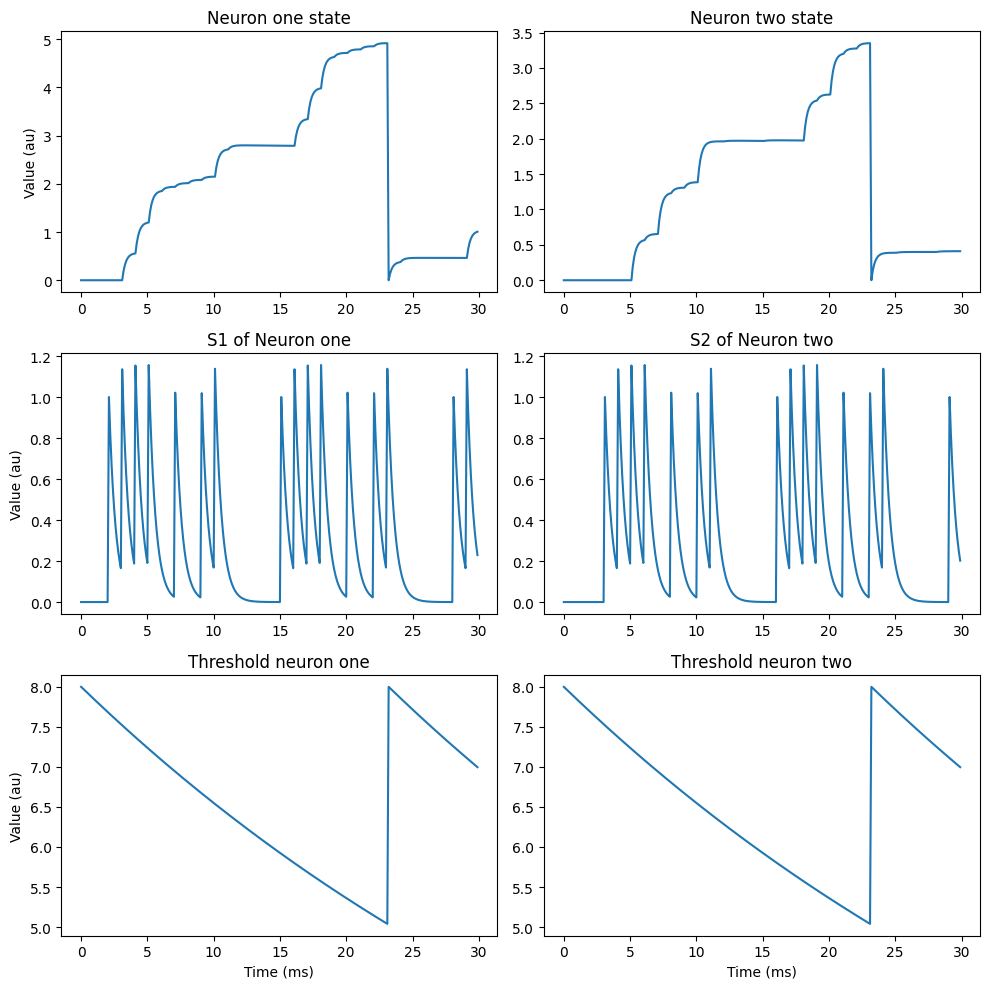

In [32]:
#@title Visualization of variables

fig, axs = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

axs[0, 0].plot(state_mon_1.t / br.ms, state_mon_1.v_1[0])
axs[0, 0].set_title('Neuron one state')
axs[0, 1].plot(state_mon_2.t / br.ms, state_mon_2.v_2[0])
axs[0, 1].set_title('Neuron two state')
axs[1, 0].plot(state_mon_3.t / br.ms, state_mon_3.s_1[0])
axs[1, 0].set_title('S1 of Neuron one')
axs[1, 1].plot(state_mon_4.t / br.ms, state_mon_4.s_2[0])
axs[1, 1].set_title('S2 of Neuron two')
axs[2, 0].plot(state_mon_5.t / br.ms, state_mon_5.v_th1[0])
axs[2, 0].set_title('Threshold neuron one')
axs[2, 1].plot(state_mon_6.t / br.ms, state_mon_6.v_th2[0])
axs[2, 1].set_title('Threshold neuron two')
for i, ax in enumerate(axs.flat):
    if i >= 4:
        ax.set(xlabel='Time (ms)')
    if i%2 == 0:
        ax.set(ylabel='Value (au)')
plt.tight_layout()


This is just a concept with some initial code. I 80% confident this can work if I found a way to make delays dynamic in brian. 

# Summary and future prospects


I have demonstrated a differentiable delay layer that can be inserted in any architecture for dealy optimization. Also, the effect of tau on learning of a single delay layer is shown. For a single delay layer, it is a non-convex optimization probem, and if the input is stochastic, it is also a stochastic optimization problem. The main challenges for differentiable delays are the form of the synaptic integration function and the loss function.


Depsite the above results, it is still difficult to co-train delays and weights and this needs further investigation. As I mentioned before, cross-entropy might not work well with delays. Maybe we need different loss functions? Lucky guess of the learning rates?

What can be done now?

- For single delay layer optimization: we need to study varioius synaptic integration functions, loss functions, the effect of various varaibles, non-convex optimization and stochastic optimization. For a start on stochastic optimzation see: https://www.frontiersin.org/articles/10.3389/fncom.2017.00104/full

- For co-learning of Delays and Weights: we need two investigate separate loss functions, or another loss function than CE, add some reguarlization terms, investigate the effect of relevant variables (like Learing rate) on performance.

- For biologically plausible delay learning: We need to find a way to make delays dynamic during a run in Brian.

As seen from the above points, there is much to do and I would appreciate feedback and cooberation.

Finally, I would like to note that this took tens of hours of me. I don't mind if anyone would use any part of this code. However, I would appreciate it and be grateful if I am noticed. I am looking for a job and some collaborations :) (when one looking for a home, they are more or less beggers haha). Regardless, anyone can use this code. 